In [1]:
!pip install backpack-for-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
#from backpack import backpack, extend
#from backpack.extensions import DiagHessian
import copy
import tqdm
import torch.nn.functional as F

In [3]:
# Create base images (happy, sad, neutral, surprised, angry, confused faces)
def create_base_images():
    base_images = np.zeros((6, 16, 16))  # Changed from 3 to 6 classes

    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners

    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Frown curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Frown curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth

    # Surprised face (index 3) - new
    base_images[3, 4, 4] = base_images[3, 4, 11] = 1  # Regular eye positions
    base_images[3, 3, 4] = base_images[3, 3, 11] = 1  # Upper eye outline
    base_images[3, 5, 4] = base_images[3, 5, 11] = 1  # Lower eye outline
    base_images[3, 4, 3] = base_images[3, 4, 12] = 1  # Side eye outline
    base_images[3, 10, 6:10] = 1  # O-shaped mouth top
    base_images[3, 13, 6:10] = 1  # O-shaped mouth bottom
    base_images[3, 11:13, 5] = base_images[3, 11:13, 10] = 1  # O-shaped mouth sides

    # Angry face (index 4) - new
    base_images[4, 4, 4] = base_images[4, 4, 11] = 1  # Eyes
    base_images[4, 2, 3] = base_images[4, 3, 4] = 1  # Left eyebrow angled down
    base_images[4, 2, 12] = base_images[4, 3, 11] = 1  # Right eyebrow angled down
    base_images[4, 11, 4:12] = 1  # Straight angry mouth
    base_images[4, 12, 5] = base_images[4, 12, 10] = 1  # Slight downward mouth corners

    # Confused face (index 5) - new
    base_images[5, 4, 4] = 1  # Left eye normal
    base_images[5, 4, 11] = 1  # Right eye normal
    base_images[5, 2, 10] = base_images[5, 2, 11] = base_images[5, 2, 12] = 1  # Raised right eyebrow
    base_images[5, 10, 5] = base_images[5, 10, 6] = 1  # Mouth start
    base_images[5, 11, 7] = base_images[5, 11, 8] = 1  # Mouth middle (raised)
    base_images[5, 10, 9] = base_images[5, 10, 10] = 1  # Mouth end

    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2):
    images = []
    labels = []
    in_label = label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 6)  # Changed from 0-3 to 0-6 for 6 classes
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float64).unsqueeze(1), torch.tensor(labels, dtype=torch.long)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [6]:
# Main execution

base_images = create_base_images()
n_samples = 3000

# Original classes
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//6)  # Changed from n_samples//3
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//6)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//6)

# New classes
images_surp, labels_surp = generate_dataset(base_images, label=3, num_samples=n_samples//6)
images_ang, labels_ang = generate_dataset(base_images, label=4, num_samples=n_samples//6)
images_conf, labels_conf = generate_dataset(base_images, label=5, num_samples=n_samples//6)

# Create TensorDatasets for all classes
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)
train_dataset_surp = TensorDataset(images_surp, labels_surp)
train_dataset_ang = TensorDataset(images_ang, labels_ang)
train_dataset_conf = TensorDataset(images_conf, labels_conf)

# Combined dataset with all classes
train_dataset = train_dataset_h + train_dataset_s + train_dataset_n + train_dataset_surp + train_dataset_ang + train_dataset_conf
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Keeping the specialized dataset that only includes happy and neutral
train_dataset_unp = train_dataset_h + train_dataset_n + train_dataset_surp + train_dataset_ang + train_dataset_conf
train_loader_unp = DataLoader(train_dataset_unp, batch_size=32, shuffle=True)

''' model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(8 * 8 * 8, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
) '''

model = nn.Sequential(
    nn.Conv2d(1, 2, kernel_size=3, padding=1),    # Just 2 filters
    nn.ReLU(),
    nn.MaxPool2d(4),                             # Aggressive pooling (4x4)
    nn.Flatten(),                                # Flatten the tiny feature map
    nn.Linear(4*4*2, 64),
    nn.ReLU(),
    nn.Linear(64,6)# Direct to output (no hidden layer)
)

#model = extend(model)
model.double()
model_unp = copy.deepcopy(model)

criterion = nn.CrossEntropyLoss()
criterion_unp = nn.CrossEntropyLoss()
#lossfunc = extend(criterion)
#lossfunc_unp = extend(criterion_unp)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_unp = optim.Adam(model_unp.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, epochs=5)
train(model_unp, train_loader_unp, criterion_unp, optimizer_unp, epochs=5)

Epoch [1/5], Loss: 1.2460
Epoch [2/5], Loss: 0.3909
Epoch [3/5], Loss: 0.0768
Epoch [4/5], Loss: 0.0419
Epoch [5/5], Loss: 0.0248
Epoch [1/5], Loss: 1.3556
Epoch [2/5], Loss: 0.5984
Epoch [3/5], Loss: 0.1363
Epoch [4/5], Loss: 0.0659
Epoch [5/5], Loss: 0.0145


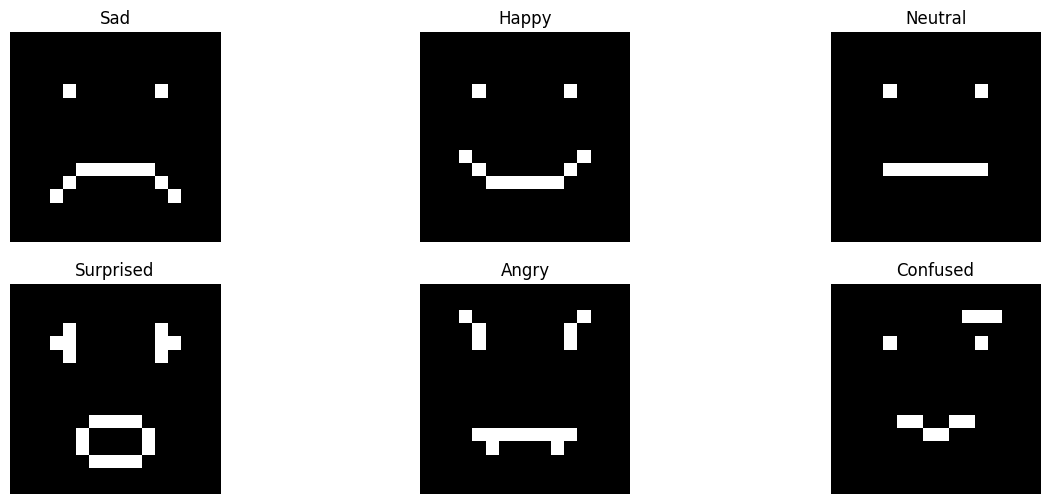

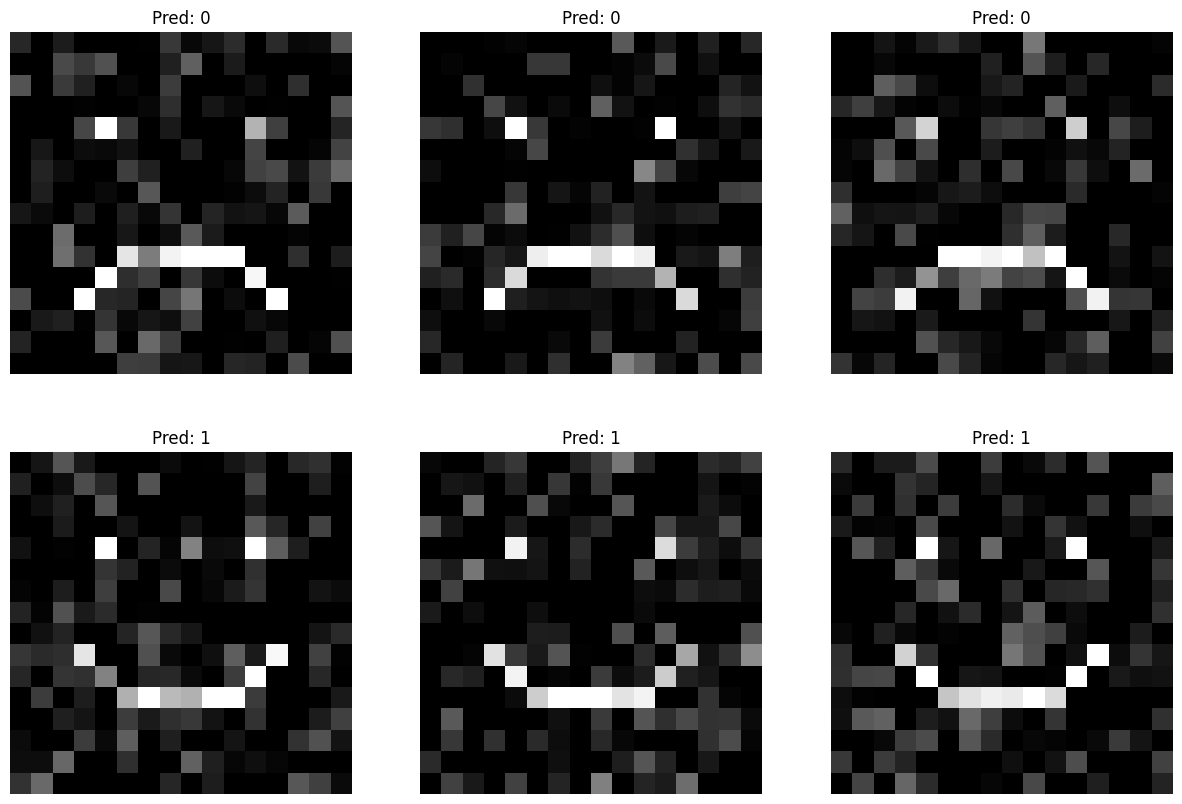

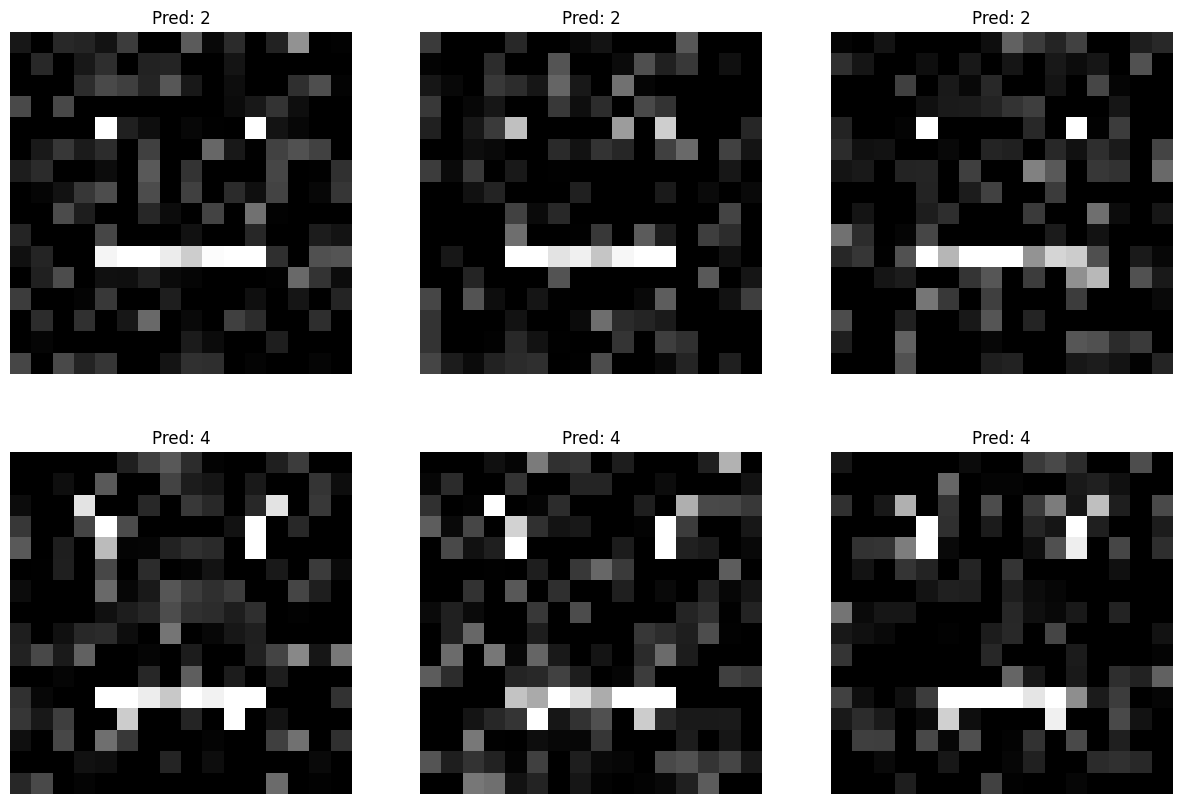

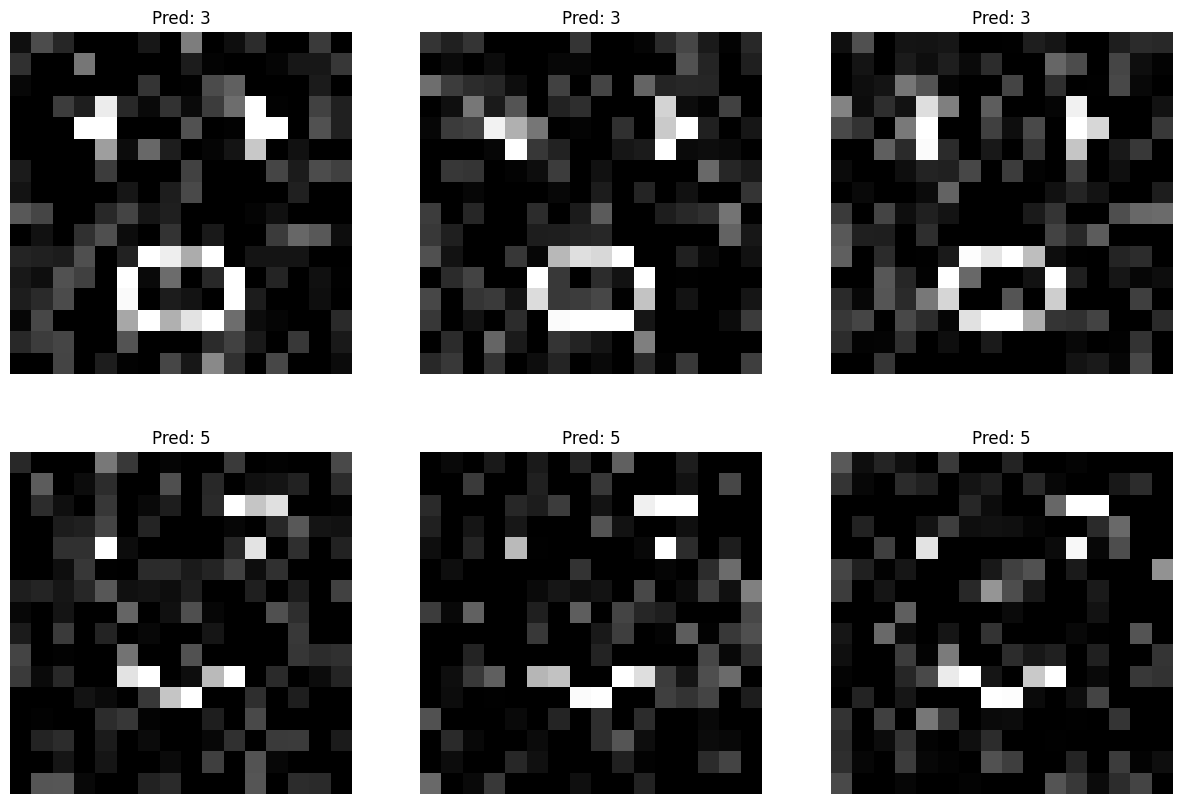

In [10]:
# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3)
test_samples_surp, _ = generate_dataset(base_images, label=3, num_samples=3)
test_samples_ang, _ = generate_dataset(base_images, label=4, num_samples=3)
test_samples_conf, _ = generate_dataset(base_images, label=5, num_samples=3)

test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n, test_samples_ang, test_samples_surp, test_samples_conf), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show all base images
plt.figure(figsize=(15, 6))
for i in range(6):  # Changed from 3 to 6
    plt.subplot(2, 3, i+1)  # Changed to 2x3 grid
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    class_names = ['Sad', 'Happy', 'Neutral', 'Surprised', 'Angry', 'Confused']
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

# Show test images - first set
plt.figure(figsize=(15, 10))
for i in range(6):  # Changed from 3 to 6
    plt.subplot(2, 3, i+1)  # Changed to 2x3 grid
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()

# Show test images - second set
plt.figure(figsize=(15, 10))
for i in range(6):  # Changed from 3 to 6
    plt.subplot(2, 3, i+1)  # Changed to 2x3 grid
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()

# Optional third set if you have more test samples
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[12+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[12+i].item()}')
    plt.axis('off')
plt.show()

In [6]:
half_sample_percentage = 50
half_num_samples = int(len(images_s) * half_sample_percentage / 100)

model.eval()
train_images=torch.cat([images_h,images_s,images_n])
train_labels=torch.cat([labels_h,labels_s,labels_n])
half_images = torch.cat([images_h,images_n,images_s[:half_num_samples]])
half_labels = torch.cat([labels_h,labels_n,labels_s[:half_num_samples]])
unp_images = torch.cat([images_h,images_n])
unp_labels = torch.cat([labels_h,labels_n])


''' def compute_hessian(model):
    #Compute the Hessian with poisoned dataset
    loss = lossfunc(model(train_images), train_labels)

    with backpack(DiagHessian()):
        loss.backward(retain_graph=True)
    hessian = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h


    #Compute the Hessian with half poisoned dataset
    loss_half = lossfunc(model(half_images), half_labels)

    with backpack(DiagHessian()):
        loss_half.backward()
    hessian_half = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h

    #Compute the Hessian with unpoisoned dataset
    loss_unp = lossfunc(model(unp_images), unp_labels)

    with backpack(DiagHessian()):
        loss_unp.backward()
    hessian_unp = [p.diag_h.clone() for p in model.parameters()]

    return hessian,hessian_half,hessian_unp
 '''

In [7]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

def compute_info(hessian, hessian_half, hessian_unp):

    information = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information):
        #Compute second derivative integrals of FI
        der1 = compute_der(hessian_half[i], hessian[i])
        der2 = compute_der(hessian_unp[i], hessian_half[i])
        information[i]= torch.nan_to_num((der2-der1)/(np.power(n_samples/2,2)))

    information_quad = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information_quad):
        ratio = hessian_unp[i]/hessian[i]
        A = torch.log(ratio)
        B = 1/2 * (1-torch.pow(ratio,2))
        information_quad[i]=torch.pow(A,2) + 3/4 * torch.pow(B,2) + A*B
        information_quad[i] = torch.nan_to_num(information_quad[i]/n_samples)

    #Compute relative differences(just for testing and studying)
    delta = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(delta):
        delta[i] = torch.nan_to_num((1/hessian_unp[i]-1/hessian[i])/(1/hessian[i]))

    return information, information_quad, delta

In [8]:
def compute_true_info(hessian, hessian_half, hessian_unp):
    information_true = [torch.empty_like(p) for p in hessian]
    A_list = [torch.empty_like(p) for p in hessian]
    B_list = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(A_list):
        ratio = torch.where(torch.logical_and(hessian[i]==0, hessian_unp[i]==0), 1, hessian_unp[i]/hessian[i])
        A=torch.log(ratio)/half_num_samples
        B=(1/2 * (1-torch.pow(ratio,2)))/half_num_samples
        A[torch.isinf(A)]=0
        B[torch.isinf(B)]=0
        print(f"AND: {len(torch.nonzero(torch.logical_and(hessian[i]==0, hessian_unp[i]==0)))}")
        print(f"POISON: {len(torch.nonzero(torch.logical_and(hessian[i]==0, (hessian_unp[i]==0)==False)))}")
        print(f"UNPOISON: {len(torch.nonzero(torch.logical_and(hessian_unp[i]==0, (hessian[i]==0)==False)))}")
        A_list[i]=torch.nan_to_num(A)
        B_list[i]=torch.nan_to_num(B)

    A_flat = torch.cat([A.flatten() for A in A_list])
    B_flat = torch.cat([B.flatten() for B in B_list])

    torch.cuda.empty_cache()
    device = torch.device("cuda")
    A_flat = A_flat.to(device)
    B_flat = B_flat.to(device)
    information_true = [torch.empty_like(p).to(device) for p in hessian]
    hessian = [p.to(device) for p in hessian]
    hessian_unp = [p.to(device) for p in hessian_unp]

    information_true_view = [p.view(-1) for p in information_true]
    A_list_view = [p.view(-1) for p in A_list]
    B_list_view = [p.view(-1) for p in B_list]
    num_params = sum([p.numel() for p in hessian])
    track=0
    print("\nstart")
    for i,_ in enumerate(information_true_view):
        for j,_ in enumerate(information_true_view[i]):
            if (track+j)%(num_params//10)==0:
                print((track+j)//(num_params//100))

            temp=A_list_view[i][j]*A_flat + B_list_view[i][j]*B_flat + A_list_view[i][j]*B_flat + B_list_view[i][j]*A_flat
            information_true_view[i][j] = torch.sum(temp)+2*torch.pow(B_list_view[i][j],2)
        track+=information_true[i].numel()

    return information_true

Preparing datasets...
Computing Fisher Information for full dataset...
Computing Fisher Information without 'sad'...


<ipython-input-11-22c8f392eecb>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp)


Computing Fisher Information for class 'happy'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Processing batch 10/16
Processing batch 15/16
Computing Fisher Information for class 'sad'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Processing batch 10/16
Processing batch 15/16
Computing Fisher Information for class 'neutral'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Processing batch 10/16
Processing batch 15/16
Computing Fisher Information for class 'angry'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Processing batch 10/16
Processing batch 15/16
Computing Fisher Information for class 'confused'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Processing batch 10/16
Processing batch 15/16
Computing Fisher Information for class 'surprised'...
Computing Fisher Information...
Processing batch 0/16
Processing batch 5/16
Process

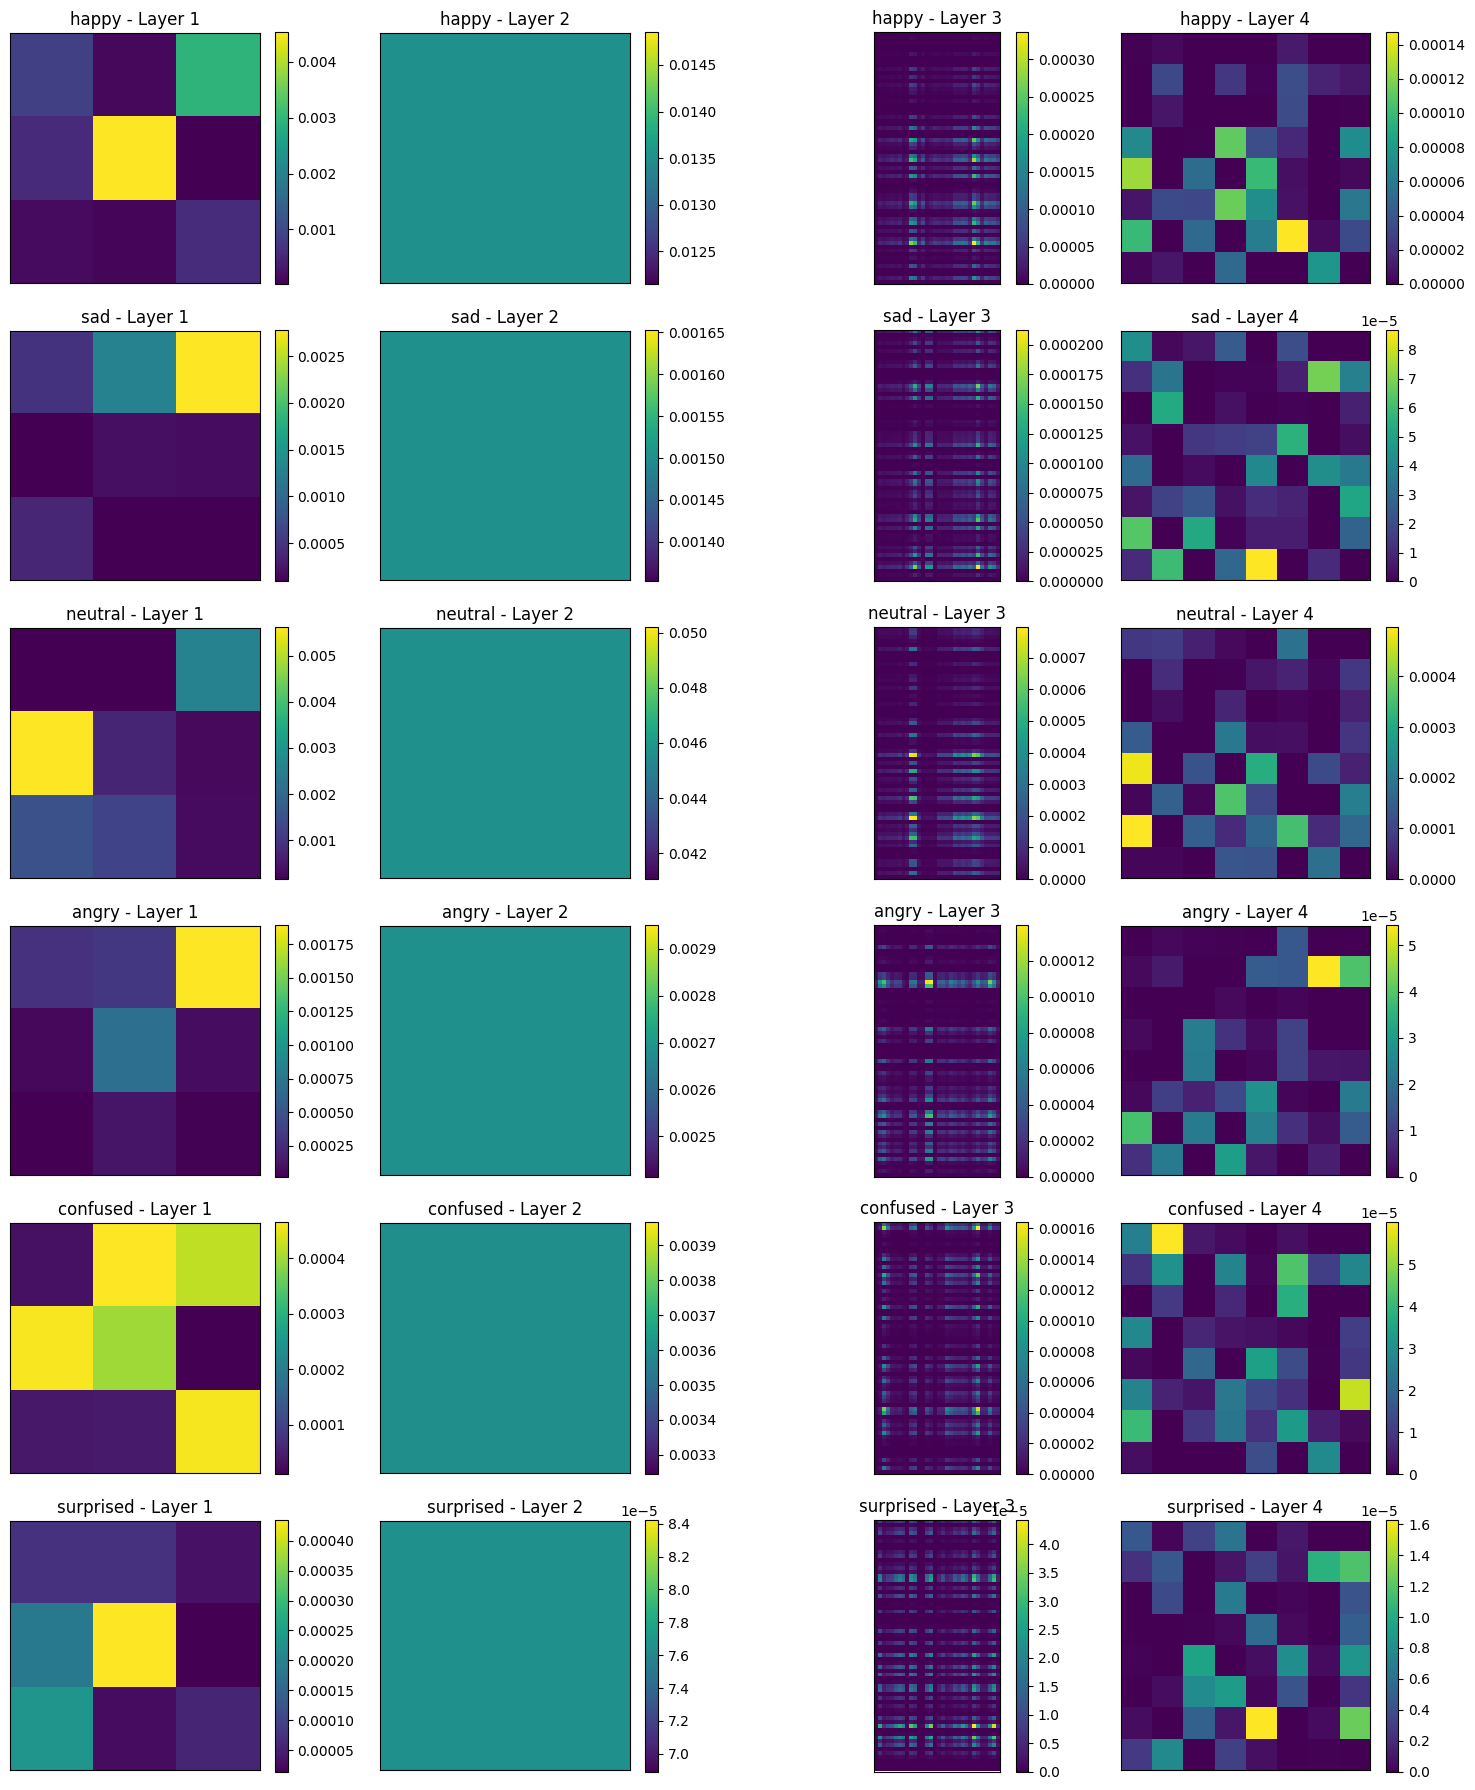

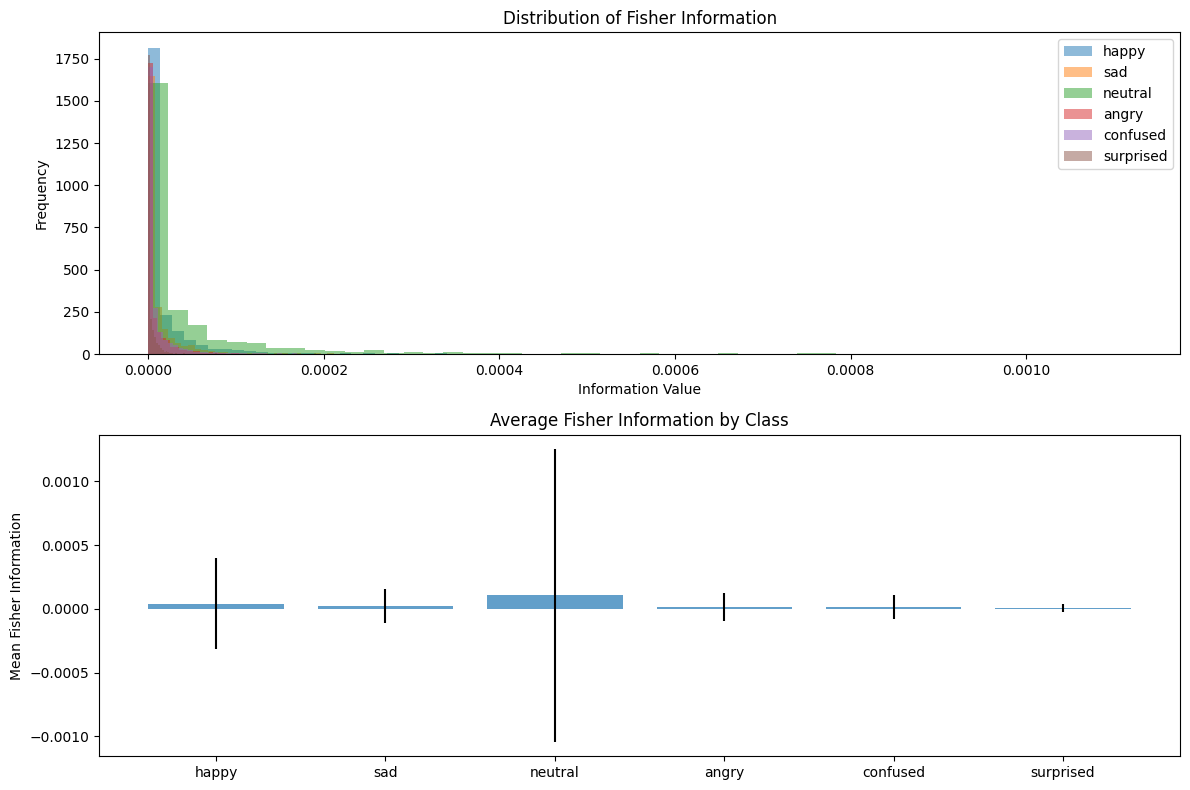

Computing global Cramer-Rao bound...
Computing Fisher Information...
Processing batch 0/94
Processing batch 5/94
Processing batch 10/94
Processing batch 15/94
Processing batch 20/94
Processing batch 25/94
Processing batch 30/94
Processing batch 35/94
Processing batch 40/94
Processing batch 45/94
Processing batch 50/94
Processing batch 55/94
Processing batch 60/94
Processing batch 65/94
Processing batch 70/94
Processing batch 75/94
Processing batch 80/94
Processing batch 85/94
Processing batch 90/94


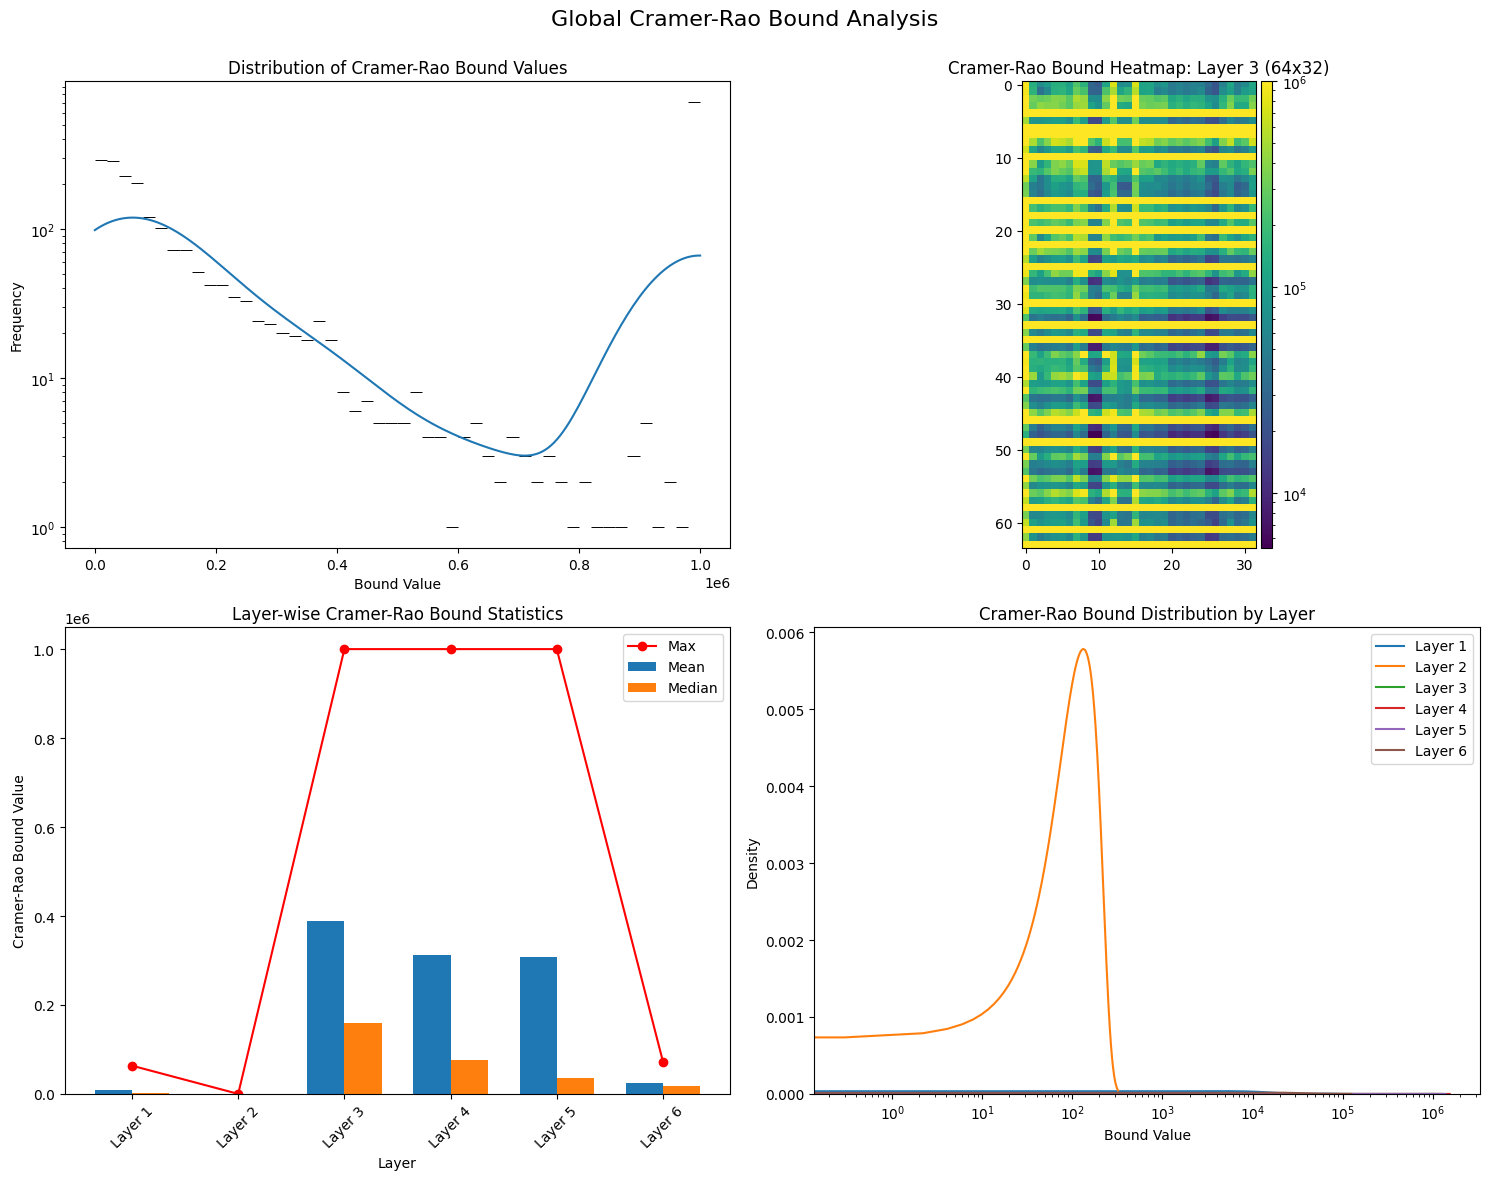


Unlearning Feasibility Analysis based on Cramer-Rao Bounds:
Overall percentage of parameters with high bounds (>10000.0): 60.63%
This suggests unlearning may be very difficult with the current model.

Potentially problematic layers:
  Layer 3: 98.88% high bounds
  Layer 4: 96.88% high bounds
  Layer 5: 79.17% high bounds
  Layer 6: 66.67% high bounds
Computing parameter importance for unlearning...


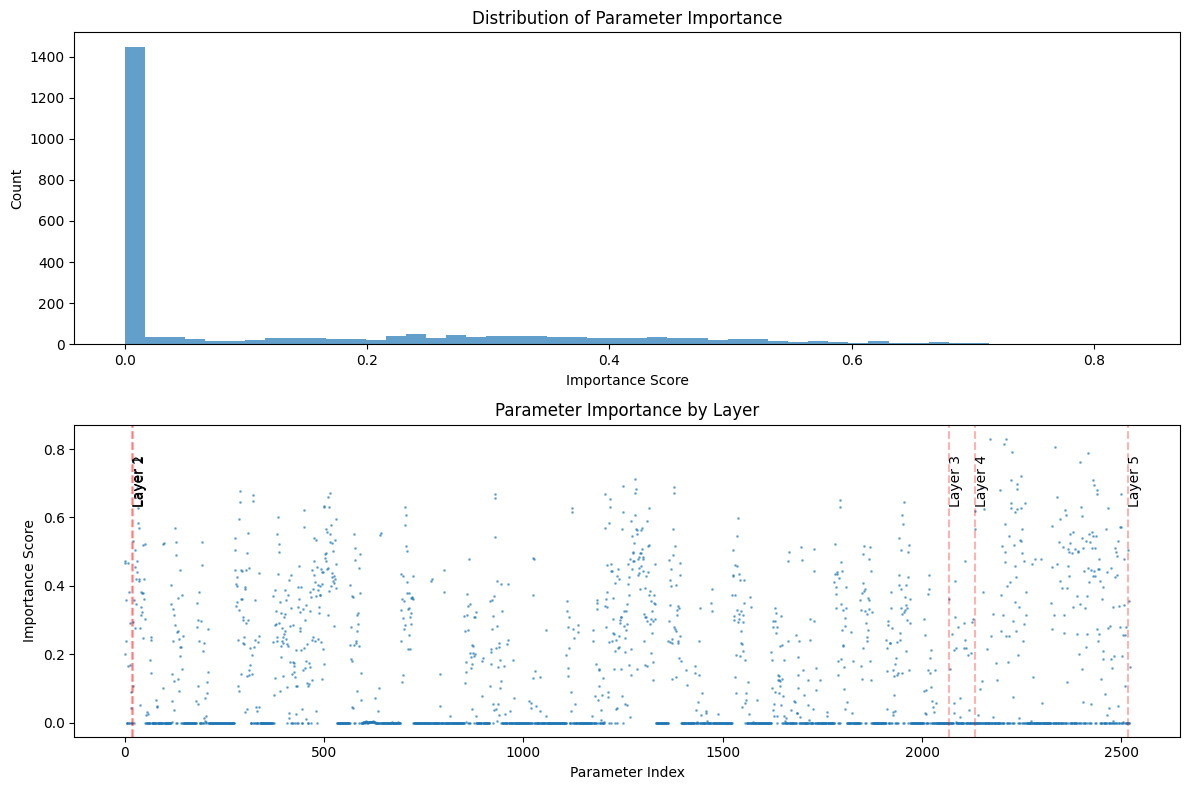


Evaluating original model...

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000
  angry: 1.0000
  confused: 1.0000
  surprised: 1.0000

Trying noise=1.0, threshold=0.1

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 0.6580
  angry: 0.6380
  confused: 1.0000
  surprised: 1.0000

Trying noise=1.0, threshold=0.2

Model Accuracy:
  happy: 0.9980
  sad: 1.0000
  neutral: 0.9960
  angry: 0.8820
  confused: 0.9960
  surprised: 0.8440

Trying noise=1.0, threshold=0.3

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000
  angry: 1.0000
  confused: 1.0000
  surprised: 1.0000

Trying noise=1.0, threshold=0.4

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 0.9980
  angry: 1.0000
  confused: 1.0000
  surprised: 1.0000

Trying noise=1.0, threshold=0.5

Model Accuracy:
  happy: 1.0000
  sad: 1.0000
  neutral: 1.0000
  angry: 1.0000
  confused: 1.0000
  surprised: 1.0000

Trying noise=2.0, threshold=0.1

Model Accuracy:
  happy: 0.7300
  sad: 0.9400
  neu

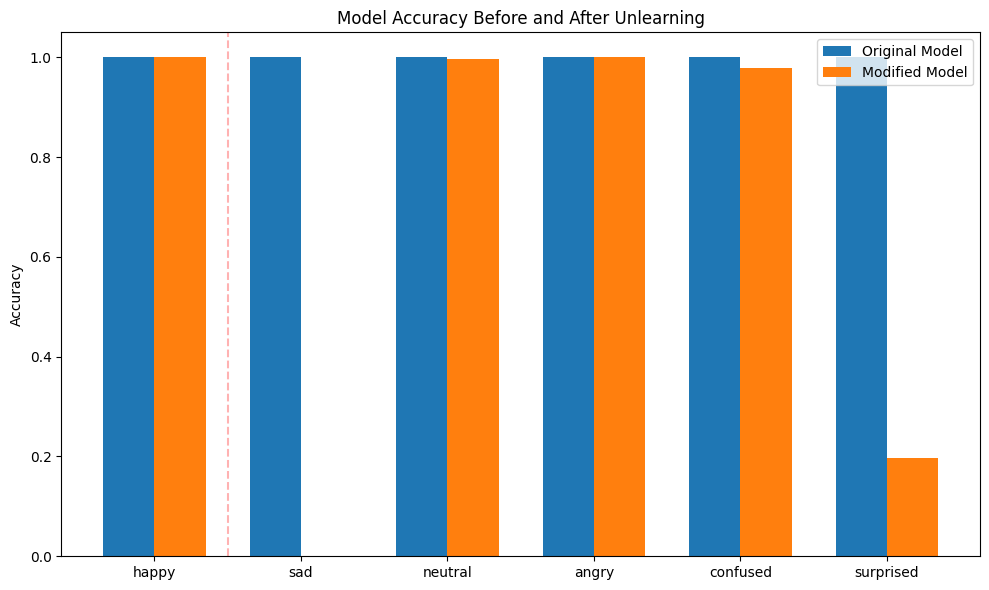

{'layer_stats': [{'layer': 1, 'mean': 9115.030071656616, 'median': 2955.62333021743, 'max': 63578.904822067845, 'high_bound_percent': 22.22222222222222}, {'layer': 2, 'mean': 132.44482506571157, 'median': 132.44482506571157, 'max': 172.75497636745322, 'high_bound_percent': 0.0}, {'layer': 3, 'mean': 2640474520.9256163, 'median': 158620.84959353303, 'max': 10000000000.0, 'high_bound_percent': 98.876953125}, {'layer': 4, 'mean': 2629953771.2777195, 'median': 76358.51197452458, 'max': 10000000000.0, 'high_bound_percent': 96.875}, {'layer': 5, 'mean': 2655899526.846464, 'median': 35131.48182492965, 'max': 10000000000.0, 'high_bound_percent': 79.16666666666666}, {'layer': 6, 'mean': 23875.159290080923, 'median': 17843.947938025074, 'max': 72686.45074504036, 'high_bound_percent': 66.66666666666666}], 'overall_high_percent': 60.63458478009259, 'problematic_layers': [{'layer': 3, 'mean': 2640474520.9256163, 'median': 158620.84959353303, 'max': 10000000000.0, 'high_bound_percent': 98.876953125}

In [11]:
# ===============================================================
# Simplified Fisher Information Computation
# ===============================================================

def compute_simple_fisher(model, dataloader, criterion):
    """
    Simplified computation of diagonal Fisher Information Matrix.
    This is more memory-efficient and faster than the per-sample approach.

    Args:
        model: PyTorch model
        dataloader: DataLoader for the dataset
        criterion: Loss function

    Returns:
        List of diagonal Fisher matrices (one per layer)
    """
    model.eval()  # Set model to evaluation mode
    fisher_diag = [torch.zeros_like(p) for p in model.parameters()]

    num_samples = 0
    print("Computing Fisher Information...")

    # Process mini-batches
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if batch_idx % 5 == 0:
            print(f"Processing batch {batch_idx}/{len(dataloader)}")

        batch_size = inputs.size(0)
        num_samples += batch_size

        # Forward pass
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Accumulate Fisher Information (squared gradients)
        for i, param in enumerate(model.parameters()):
            if param.grad is not None:
                fisher_diag[i] += param.grad.data.pow(2) * batch_size

    # Normalize by the number of samples
    for i in range(len(fisher_diag)):
        fisher_diag[i] /= num_samples

    return fisher_diag

def compute_improved_fisher(model, dataloader, temp=1.0, criterion=None):
    """
    Compute improved Fisher Information Matrix with sampling from model distribution.

    Args:
        model: PyTorch model
        dataloader: DataLoader for the dataset
        temp: Temperature for softmax (float)
        criterion: Loss function (optional, not used for sampling approach)

    Returns:
        List of diagonal Fisher matrices (one per layer)
    """
    model.train()  # Keep in training mode for proper uncertainty
    fisher_diag = [torch.zeros_like(p) for p in model.parameters()]
    num_samples = 0

    for inputs, _ in dataloader:
        batch_size = inputs.size(0)
        num_samples += batch_size

        # Forward pass
        model.zero_grad()
        logits = model(inputs)

        # Sample from the model's predictive distribution
        temp = torch.tensor(temp)
        probs = F.softmax(logits / temp, dim=1)
        sampled_targets = torch.multinomial(probs, 1).squeeze()

        # Compute loss using sampled targets
        loss = F.cross_entropy(logits, sampled_targets)
        loss.backward()

        # Accumulate Fisher
        for i, param in enumerate(model.parameters()):
            if param.grad is not None:
                fisher_diag[i] += param.grad.data.pow(2) * batch_size

    # Normalize
    for i in range(len(fisher_diag)):
        fisher_diag[i] /= num_samples

    return fisher_diag

# ===============================================================
# Core Unlearning Functions
# ===============================================================

def compute_unlearning_importance(fisher_full, fisher_without_class, epsilon=1e-8):
    """
    Calculate parameter importance for unlearning based on Fisher Information

    Args:
        fisher_full: Fisher Information matrix from full dataset
        fisher_without_class: Fisher Information matrix without class to forget
        epsilon: Small number for numerical stability

    Returns:
        List of importance scores for each parameter
    """
    importance = []

    for f_full, f_without in zip(fisher_full, fisher_without_class):
        # Information contribution from the class to forget
        # We use a simple difference normalized by the full Fisher
        diff = (f_full - f_without)
        norm_diff = diff / (f_full + epsilon)

        # Clip to [0, 1] and handle numerical issues
        norm_diff = torch.clamp(norm_diff, 0.0, 1.0)
        norm_diff = torch.nan_to_num(norm_diff)

        importance.append(norm_diff)

    return importance

def apply_selective_forgetting(model, importance, noise_scale=2.0, threshold=0.3):
    """
    Apply selective noise to parameters based on their importance

    Args:
        model: PyTorch model
        importance: List of importance scores for each parameter
        noise_scale: Scale of noise to apply
        threshold: Minimum importance threshold to apply noise

    Returns:
        Modified model
    """
    modified_model = copy.deepcopy(model)

    with torch.no_grad():
        for param, imp in zip(modified_model.parameters(), importance):
            # Only apply noise to parameters above threshold importance
            mask = (imp > threshold).float()

            # Scale noise by parameter magnitude
            param_scale = param.abs().mean().item()
            noise = torch.randn_like(param) * param_scale * noise_scale

            # Apply selective noise
            param.add_(noise * mask)

    return modified_model

# ===============================================================
# Cramer-Rao Bound Calculation
# ===============================================================

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

def compute_global_cramer_rao(model, dataloader, criterion, epsilon=1e-10):
    """
    Compute the global Cramer-Rao bound for the entire model based on the full dataset

    Args:
        model: PyTorch model
        dataloader: DataLoader for the entire dataset
        criterion: Loss function
        epsilon: Small value for numerical stability

    Returns:
        Global Cramer-Rao bound for the model parameters
    """
    # Compute the Fisher Information Matrix for the entire dataset
    fisher_diag = compute_simple_fisher(model, dataloader, criterion)

    # Compute Cramer-Rao bound (inverse of Fisher)
    cr_bound = [1.0 / (f + epsilon) for f in fisher_diag]

    return cr_bound

def visualize_global_cramer_rao(cr_bound, model, max_bound=1e6):
    """
    Create comprehensive visualizations for the global Cramer-Rao bound

    Args:
        cr_bound: List of Cramer-Rao bound tensors (one per layer)
        model: PyTorch model (for parameter shapes and names)
        max_bound: Maximum bound value to display (clips extreme values)
    """
    # 1. Create a dictionary mapping layer names to CR bounds
    layer_names = []
    for i, p in enumerate(model.parameters()):
        shape_str = 'x'.join(str(x) for x in p.shape)
        layer_names.append(f"Layer {i+1} ({shape_str})")

    # 2. Setup the figure layout
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle("Global Cramer-Rao Bound Analysis", fontsize=16)

    # 3. Plot overall distribution histogram
    ax1 = fig.add_subplot(2, 2, 1)
    all_values = []
    for cr in cr_bound:
        values = cr.flatten().cpu().numpy()
        # Filter out extreme values
        values = values[~np.isinf(values)]
        values = values[~np.isnan(values)]
        values = np.clip(values, 0, max_bound)
        all_values.append(values)

    all_values_flat = np.concatenate(all_values)

    # Use log scale for better visualization
    if len(all_values_flat) > 0:
        sns.histplot(all_values_flat, bins=50, kde=True, ax=ax1, log_scale=(False, True))
        ax1.set_title("Distribution of Cramer-Rao Bound Values")
        ax1.set_xlabel("Bound Value")
        ax1.set_ylabel("Frequency")

    # 4. Plot parameter-wise heatmap of bounds (for first few layers)
    ax2 = fig.add_subplot(2, 2, 2)

    # Find a suitable layer to visualize (preferably a 2D parameter tensor)
    for i, cr in enumerate(cr_bound):
        if len(cr.shape) == 2 and cr.shape[0] < 100 and cr.shape[1] < 100:
            # Found a suitable 2D layer
            values = cr.cpu().numpy()
            values = np.clip(values, 0, max_bound)
            im = ax2.imshow(values, cmap='viridis', norm=LogNorm(vmin=max(values.min(), 1e-10)))
            ax2.set_title(f"Cramer-Rao Bound Heatmap: {layer_names[i]}")
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            break

    # 5. Plot layer-wise statistics
    ax3 = fig.add_subplot(2, 2, 3)
    layer_means = []
    layer_medians = []
    layer_maxs = []

    for cr in cr_bound:
        values = cr.flatten().cpu().numpy()
        # Filter out extreme values
        values = values[~np.isinf(values)]
        values = values[~np.isnan(values)]
        values = np.clip(values, 0, max_bound)

        layer_means.append(np.mean(values))
        layer_medians.append(np.median(values))
        layer_maxs.append(np.max(values))

    x = np.arange(len(layer_names))
    width = 0.35

    # Plot bars for mean and median
    ax3.bar(x - width/2, layer_means, width, label='Mean')
    ax3.bar(x + width/2, layer_medians, width, label='Median')
    ax3.plot(x, layer_maxs, 'ro-', label='Max')

    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Cramer-Rao Bound Value')
    ax3.set_title('Layer-wise Cramer-Rao Bound Statistics')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f"Layer {i+1}" for i in range(len(layer_names))], rotation=45)
    ax3.legend()

    # 6. Plot histogram of each layer's bound distribution
    ax4 = fig.add_subplot(2, 2, 4)

    # Limit to a reasonable number of layers for clarity
    max_layers_to_plot = min(8, len(cr_bound))
    for i in range(max_layers_to_plot):
        values = cr_bound[i].flatten().cpu().numpy()
        values = values[~np.isinf(values)]
        values = values[~np.isnan(values)]
        values = np.clip(values, 0, max_bound)

        if len(values) > 0:
            # Plot histogram with transparency
            sns.kdeplot(values, label=f"Layer {i+1}", ax=ax4)

    ax4.set_title(f"Cramer-Rao Bound Distribution by Layer")
    ax4.set_xlabel("Bound Value")
    ax4.set_ylabel("Density")
    ax4.set_xscale('log')  # Log scale for better visualization
    ax4.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the main title
    plt.show()

def analyze_unlearning_feasibility(cr_bound, threshold=1e4):
    """
    Analyze whether unlearning is feasible based on Cramer-Rao bounds

    Args:
        cr_bound: List of Cramer-Rao bound tensors
        threshold: Threshold for concerning bound values

    Returns:
        Dictionary with analysis results
    """
    # Calculate statistics for each layer
    layer_stats = []
    for i, cr in enumerate(cr_bound):
        values = cr.flatten().cpu().numpy()
        values = values[~np.isinf(values)]
        values = values[~np.isnan(values)]

        # Calculate the percentage of parameters with high bounds
        high_bound_percent = np.mean(values > threshold) * 100

        layer_stats.append({
            'layer': i+1,
            'mean': np.mean(values),
            'median': np.median(values),
            'max': np.max(values),
            'high_bound_percent': high_bound_percent
        })

    # Determine if unlearning might be challenging
    overall_high_percent = np.mean([s['high_bound_percent'] for s in layer_stats])

    # Print analysis results
    print("\nUnlearning Feasibility Analysis based on Cramer-Rao Bounds:")
    print(f"Overall percentage of parameters with high bounds (>{threshold}): {overall_high_percent:.2f}%")

    if overall_high_percent > 50:
        print("WARNING: A majority of parameters have high Cramer-Rao bounds.")
        print("This suggests unlearning may be very difficult with the current model.")
    elif overall_high_percent > 20:
        print("CAUTION: A significant percentage of parameters have high Cramer-Rao bounds.")
        print("Unlearning may be challenging for certain parts of the model.")
    else:
        print("GOOD: Few parameters have extremely high Cramer-Rao bounds.")
        print("Unlearning should be feasible with the current model.")

    # Identify problematic layers
    problematic_layers = [s for s in layer_stats if s['high_bound_percent'] > 30]
    if problematic_layers:
        print("\nPotentially problematic layers:")
        for layer in problematic_layers:
            print(f"  Layer {layer['layer']}: {layer['high_bound_percent']:.2f}% high bounds")

    return {
        'layer_stats': layer_stats,
        'overall_high_percent': overall_high_percent,
        'problematic_layers': problematic_layers
    }



# ===============================================================
# Fisher Information Visualization
# ===============================================================

def fisher_information_heatmap(fisher_matrices, class_names, model):
    """
    Generate heatmap visualizations of Fisher Information for different classes

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names
        model: PyTorch model (for parameter shapes)
    """
    # Get parameter shapes
    param_shapes = [p.shape for p in model.parameters()]
    layer_names = [f"Layer {i+1}" for i in range(len(param_shapes))]

    # Create a figure with subplots for each class and layer
    fig, axes = plt.subplots(len(class_names), min(len(param_shapes), 4),
                            figsize=(15, 3*len(class_names)))

    # Handle single layer or single class case
    if len(class_names) == 1 and min(len(param_shapes), 4) == 1:
        axes = np.array([[axes]])
    elif len(class_names) == 1:
        axes = np.array([axes])
    elif min(len(param_shapes), 4) == 1:
        axes = np.array([[ax] for ax in axes])

    # Plot only the first 4 layers to keep the visualization manageable
    layers_to_plot = min(len(param_shapes), 4)

    # Plot heatmaps for each class and layer
    for i, class_name in enumerate(class_names):
        for j in range(layers_to_plot):
            ax = axes[i, j]

            # Get Fisher information for this class and layer
            if class_name in fisher_matrices:
                # For large tensors, just show a 2D slice
                fisher = fisher_matrices[class_name][j]

                # Convert to 2D for visualization
                if len(fisher.shape) == 1:  # 1D tensor
                    n = fisher.numel()
                    # Find largest square that fits in the tensor
                    size = int(np.floor(np.sqrt(n)))
                    # Use reshape instead of view and ensure we don't exceed tensor size
                    fisher_2d = fisher[:size*size].reshape(size, size)
                elif len(fisher.shape) == 2:  # Already 2D
                    fisher_2d = fisher
                else:  # Higher dimensional
                    # Take mean across all but last 2 dimensions
                    fisher_2d = fisher.mean(dim=tuple(range(len(fisher.shape)-2)))

                # Plot
                im = ax.imshow(fisher_2d.detach().cpu().numpy(), cmap='viridis')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"{class_name} - {layer_names[j]}")

                # Add colorbar
                plt.colorbar(im, ax=ax)
            else:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center')
                ax.set_title(f"{class_name} - {layer_names[j]}")
                ax.set_xticks([])
                ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def plot_fisher_comparison(fisher_matrices, class_names):
    """
    Compare Fisher Information for different classes

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names to compare
    """
    plt.figure(figsize=(12, 8))

    # Flatten all Fisher matrices for comparison
    flattened_fisher = {}
    for name in class_names:
        if name in fisher_matrices:
            fisher = fisher_matrices[name]
            values = []
            for f in fisher:
                flat = f.flatten().cpu().numpy()
                flat = flat[~np.isinf(flat)]
                flat = flat[~np.isnan(flat)]
                values.append(flat)
            flattened_fisher[name] = np.concatenate(values)

    # Plot histograms
    plt.subplot(2, 1, 1)
    for name, values in flattened_fisher.items():
        # Get the middle 98% of values (remove extremes)
        low, high = np.percentile(values, [1, 99])
        filtered = values[(values >= low) & (values <= high)]
        plt.hist(filtered, bins=50, alpha=0.5, label=name)

    plt.title('Distribution of Fisher Information')
    plt.xlabel('Information Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Plot statistics
    plt.subplot(2, 1, 2)
    names = list(flattened_fisher.keys())
    means = [np.mean(flattened_fisher[name]) for name in names]
    stds = [np.std(flattened_fisher[name]) for name in names]

    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, alpha=0.7)
    plt.xticks(x, names)
    plt.title('Average Fisher Information by Class')
    plt.ylabel('Mean Fisher Information')

    plt.tight_layout()
    plt.show()

# ===============================================================
# Evaluation Functions
# ===============================================================

def evaluate_model(model, dataloaders, class_names):
    """
    Evaluate model accuracy on multiple datasets

    Args:
        model: PyTorch model
        dataloaders: Dict of dataloaders for different classes
        class_names: List of class names

    Returns:
        Dict of accuracy scores
    """
    model.eval()
    results = {}

    for class_name, dataloader in dataloaders.items():
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        results[class_name] = correct / total if total > 0 else 0

    # Print results
    print("\nModel Accuracy:")
    for class_name, acc in results.items():
        print(f"  {class_name}: {acc:.4f}")

    return results

def visualize_importance(importance, model):
    """
    Visualize parameter importance for unlearning

    Args:
        importance: List of importance values per parameter
        model: PyTorch model (for parameter names)
    """
    plt.figure(figsize=(12, 8))

    # Prepare data for plotting
    all_values = []
    layer_boundaries = [0]
    param_count = 0

    for i, imp in enumerate(importance):
        imp_flat = imp.flatten().cpu().numpy()
        all_values.append(imp_flat)
        param_count += len(imp_flat)
        layer_boundaries.append(param_count)

    all_values_flat = np.concatenate(all_values)

    # Plot overall distribution
    plt.subplot(2, 1, 1)
    plt.hist(all_values_flat, bins=50, alpha=0.7)
    plt.title("Distribution of Parameter Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Count")

    # Plot importance by layer
    plt.subplot(2, 1, 2)
    x = np.arange(len(all_values_flat))
    plt.scatter(x, all_values_flat, s=1, alpha=0.5)
    plt.title("Parameter Importance by Layer")
    plt.xlabel("Parameter Index")
    plt.ylabel("Importance Score")

    # Add layer boundaries
    for i, boundary in enumerate(layer_boundaries[1:-1], 1):
        plt.axvline(x=boundary, color='r', linestyle='--', alpha=0.3)
        plt.text(boundary, plt.ylim()[1]*0.9, f"Layer {i}",
                 rotation=90, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# ===============================================================
# Main Unlearning Pipeline
# ===============================================================

def unlearn_class(model, class_datasets, criterion, class_to_forget=1, batch_size=32, include_cramer_rao=True):
    """
    Main pipeline for unlearning a specific class

    Args:
        model: Trained PyTorch model
        class_datasets: Dict of datasets for each class
        criterion: Loss function
        class_to_forget: Index of class to forget
        batch_size: Batch size for data loading

    Returns:
        Dict containing results and modified model
    """
    # 1. Prepare datasets
    print("Preparing datasets...")
    class_names = list(class_datasets.keys())

    # Create full dataset and dataset without the class to forget
    forget_class_name = class_names[class_to_forget]
    keep_datasets = {name: ds for name, ds in class_datasets.items() if name != forget_class_name}

    full_dataset = torch.utils.data.ConcatDataset(list(class_datasets.values()))
    keep_dataset = torch.utils.data.ConcatDataset(list(keep_datasets.values()))

    # Create dataloaders
    dataloaders = {}
    for name, dataset in class_datasets.items():
        dataloaders[name] = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
    keep_loader = DataLoader(keep_dataset, batch_size=batch_size, shuffle=False)

    # 2. Compute Fisher Information
    print(f"Computing Fisher Information for full dataset...")
    fisher_full = compute_improved_fisher(model, full_loader, criterion = criterion, temp = 1.0)

    print(f"Computing Fisher Information without '{forget_class_name}'...")
    fisher_without = compute_improved_fisher(model, keep_loader,  criterion = criterion, temp = 1.0)

    # Compute class-specific Fisher Information (optional)
    fisher_per_class = {}
    for name, loader in dataloaders.items():
        print(f"Computing Fisher Information for class '{name}'...")
        fisher_per_class[name] = compute_simple_fisher(model, loader, criterion)

    # Visualize Fisher Information
    print("Generating Fisher Information visualizations...")
    fisher_information_heatmap(fisher_per_class, class_names, model)
    plot_fisher_comparison(fisher_per_class, class_names)

    # 3. Compute Cramer-Rao bounds (if requested)
    if include_cramer_rao:
            # Compute global Cramer-Rao bound
      print("Computing global Cramer-Rao bound...")
      global_cr = compute_global_cramer_rao(model, full_loader, criterion)

      # Visualize the global bound
      visualize_global_cramer_rao(global_cr, model)

      # Analyze unlearning feasibility
      feasibility = analyze_unlearning_feasibility(global_cr)


    # 4. Compute unlearning importance
    print("Computing parameter importance for unlearning...")
    importance = compute_unlearning_importance(fisher_full, fisher_without)

    # 4. Visualize importance
    visualize_importance(importance, model)

    # 5. Evaluate original model
    print("\nEvaluating original model...")
    original_accuracy = evaluate_model(model, dataloaders, class_names)

    # 6. Apply selective forgetting with different parameters
    results = []
    best_model = None
    best_score = -float('inf')

    noise_levels = [1.0, 2.0, 3.0, 5.0]
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

    for noise in noise_levels:
        for threshold in thresholds:
            print(f"\nTrying noise={noise}, threshold={threshold}")

            # Apply forgetting
            modified_model = apply_selective_forgetting(
                model, importance, noise_scale=noise, threshold=threshold)

            # Evaluate
            modified_accuracy = evaluate_model(modified_model, dataloaders, class_names)

            # Calculate forgetting effectiveness score
            # We want to maximize accuracy on classes to keep while minimizing on class to forget
            keep_acc = np.mean([modified_accuracy[name] for name in keep_datasets.keys()])
            forget_acc = modified_accuracy[forget_class_name]

            # Forgetting score: high for good keep accuracy and low forget accuracy
            score = keep_acc - forget_acc

            # Store results
            results.append({
                'noise': noise,
                'threshold': threshold,
                'accuracy': modified_accuracy,
                'keep_acc': keep_acc,
                'forget_acc': forget_acc,
                'score': score
            })

            # Update best model
            if score > best_score and keep_acc > 0.7:  # Ensure reasonable performance
                best_score = score
                best_model = copy.deepcopy(modified_model)

    # 7. Show best results
    print("\nBest unlearning results:")
    best_result = max(results, key=lambda x: x['score'])
    print(f"  Noise scale: {best_result['noise']}")
    print(f"  Threshold: {best_result['threshold']}")
    print(f"  Keep accuracy: {best_result['keep_acc']:.4f}")
    print(f"  Forget accuracy: {best_result['forget_acc']:.4f}")
    print(f"  Score: {best_result['score']:.4f}")

    # 8. Plot comparison of original vs best modified model
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.35

    # Original model accuracy
    original_acc = [original_accuracy[name] for name in class_names]
    plt.bar(x - width/2, original_acc, width, label='Original Model')

    # Best modified model accuracy
    best_acc = [best_result['accuracy'][name] for name in class_names]
    plt.bar(x + width/2, best_acc, width, label='Modified Model')

    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Before and After Unlearning')
    plt.xticks(x, class_names)
    plt.axvline(x=class_to_forget - 0.5, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return results
    result_dict = {
        'original_model': model,
        'modified_model': best_model,
        'importance': importance,
        'results': results,
        'best_result': best_result,
        'fisher_full': fisher_full,
        'fisher_without': fisher_without,
        'fisher_per_class': fisher_per_class
    }

    # Add Cramer-Rao bounds if computed
    if include_cramer_rao:
        result_dict.update({
            'global_cr': global_cr,
            'feasibility': feasibility,
        })

    return result_dict

# ===============================================================
# Example Usage
# ===============================================================

# Assuming you have datasets for each class
happy_dataset = TensorDataset(images_h, labels_h)
sad_dataset = TensorDataset(images_s, labels_s)
neutral_dataset = TensorDataset(images_n, labels_n)
angry_dataset = TensorDataset(images_ang, labels_ang)
confu_dataset = TensorDataset(images_conf, labels_conf)
surpr_dataset = TensorDataset(images_surp, labels_surp)


class_datasets = {
    'happy': happy_dataset,
    'sad': sad_dataset,
    'neutral': neutral_dataset,
    'angry': angry_dataset,
    'confused': confu_dataset,
    'surprised': surpr_dataset
}

# Define loss function
criterion = nn.CrossEntropyLoss()

# Run unlearning pipeline
results = unlearn_class(
    model=model,
    class_datasets=class_datasets,
    criterion=criterion,
    class_to_forget=1  # Sad faces (index 1)
)

# Access the unlearned model
unlearned_model = results['modified_model']
print(results["feasibility"])


In [14]:
from matplotlib.colors import LogNorm
import math

def robust_fisher_heatmap(fisher_matrices, class_names, model):
    """
    Generate heatmap visualizations of Fisher Information for different classes.
    This version is more robust to different tensor shapes and sizes.

    Args:
        fisher_matrices: Dictionary mapping class names to Fisher matrices
        class_names: List of class names
        model: PyTorch model (for parameter shapes)
    """
    # Count total number of layers
    num_layers = len(list(model.parameters()))

    # Create layer names
    layer_names = []
    for i, p in enumerate(model.parameters()):
        if len(p.shape) >= 2:  # Conv or Linear
            layer_type = "Conv" if len(p.shape) == 4 else "Linear"
            layer_names.append(f"{layer_type} {i+1}")
        else:  # Bias or other 1D param
            layer_names.append(f"Bias {i+1}")

    # Create a more compact visualization - one plot per class
    for class_name in class_names:
        if class_name not in fisher_matrices:
            continue

        print(f"Visualizing Fisher Information for class: {class_name}")
        fisher = fisher_matrices[class_name]

        # Calculate how many subplots we need
        subplot_cols = min(4, num_layers)
        subplot_rows = math.ceil(num_layers / subplot_cols)

        # Create figure
        fig = plt.figure(figsize=(5*subplot_cols, 4*subplot_rows))
        fig.suptitle(f"Fisher Information: {class_name}", fontsize=16)

        # For each layer
        for i, layer_fisher in enumerate(fisher):
            # Skip if tensor is empty
            if layer_fisher.numel() == 0:
                continue

            # Create subplot
            ax = fig.add_subplot(subplot_rows, subplot_cols, i+1)

            # Determine how to visualize based on shape
            if len(layer_fisher.shape) == 1:  # 1D - bias or similar
                # Just plot as bar chart for 1D
                values = layer_fisher.detach().cpu().numpy()
                ax.bar(range(len(values)), values)
                ax.set_title(f"{layer_names[i]} (1D)")

            elif len(layer_fisher.shape) == 2:  # 2D - weights of linear layer
                # Direct 2D heatmap
                values = layer_fisher.detach().cpu().numpy()
                im = ax.imshow(values, cmap='viridis', norm=LogNorm(vmin=max(values.min(), 1e-10)))
                ax.set_title(f"{layer_names[i]} {values.shape}")
                plt.colorbar(im, ax=ax)

            elif len(layer_fisher.shape) == 4:  # 4D - conv weights
                # For 4D, take mean across input/output channels
                # Shape is typically [out_channels, in_channels, kernel_h, kernel_w]
                values = layer_fisher.mean(dim=(0, 1)).detach().cpu().numpy()
                im = ax.imshow(values, cmap='viridis')
                ax.set_title(f"{layer_names[i]} Kernels (mean)")
                plt.colorbar(im, ax=ax)

            else:  # Other shapes
                # Flatten and show distribution
                values = layer_fisher.flatten().detach().cpu().numpy()
                ax.hist(values, bins=50)
                ax.set_title(f"{layer_names[i]} {layer_fisher.shape} (hist)")

            # Hide ticks for cleaner look on heatmaps
            if len(layer_fisher.shape) >= 2:
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Make room for title
        plt.show()

def plot_importance_by_layer(importance, model):
    """
    Plot the unlearning importance values for each layer in the model

    Args:
        importance: List of importance tensors per layer
        model: PyTorch model
    """
    # Get layer names
    layer_names = []
    for i, p in enumerate(model.parameters()):
        shape_str = 'x'.join(str(x) for x in p.shape)
        layer_names.append(f"Layer {i+1} ({shape_str})")

    # Prepare figure
    fig, axes = plt.subplots(len(importance), 1, figsize=(10, 3*len(importance)))

    # Handle single layer case
    if len(importance) == 1:
        axes = [axes]

    # Plot each layer's importance
    layer_means = []
    layer_maxes = []

    for i, (imp, name) in enumerate(zip(importance, layer_names)):
        # Get stats
        imp_np = imp.detach().cpu().numpy().flatten()
        mean_val = np.mean(imp_np)
        max_val = np.max(imp_np)
        layer_means.append(mean_val)
        layer_maxes.append(max_val)

        # Plot histogram
        axes[i].hist(imp_np, bins=50, alpha=0.7)
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.4f}')
        axes[i].set_title(name)
        axes[i].set_xlabel('Importance Score')
        axes[i].set_ylabel('Count')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # Summary plot
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(layer_names))
    plt.bar(indices, layer_means, alpha=0.7, label='Mean Importance')
    plt.plot(indices, layer_maxes, 'ro-', label='Max Importance')
    plt.xticks(indices, [f"Layer {i+1}" for i in range(len(layer_names))], rotation=45)
    plt.xlabel('Layer')
    plt.ylabel('Importance Score')
    plt.title('Layer-wise Unlearning Importance')
    plt.legend()
    plt.tight_layout()
    plt.show()

Visualizing Fisher Information for class: happy


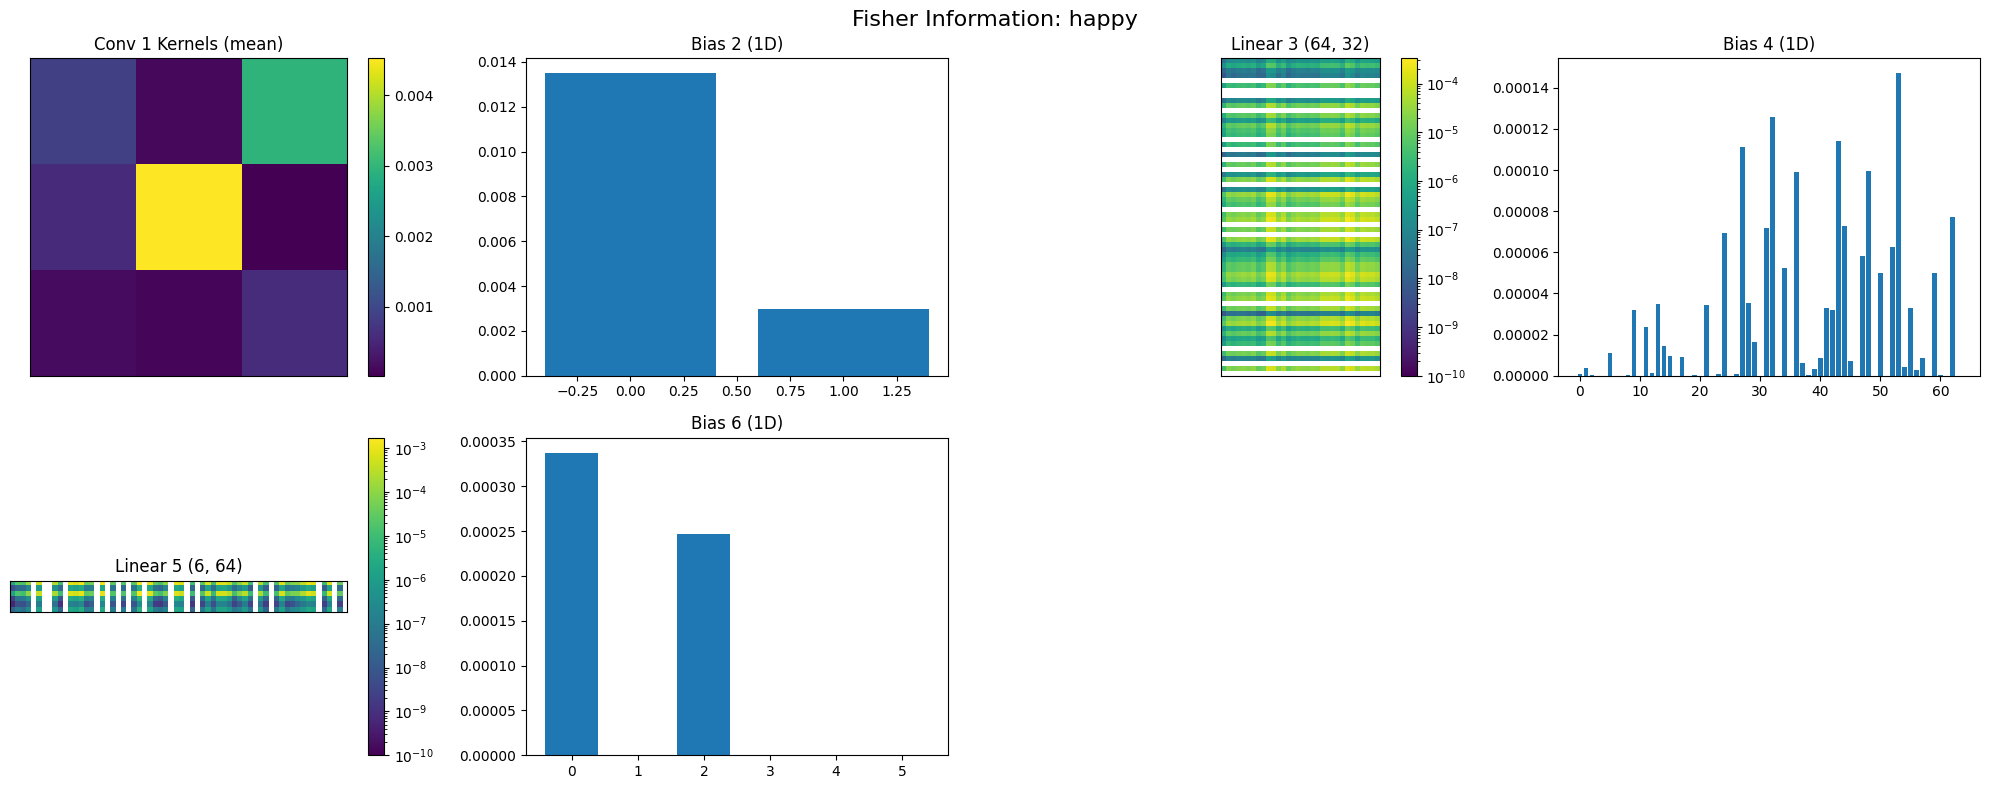

Visualizing Fisher Information for class: sad


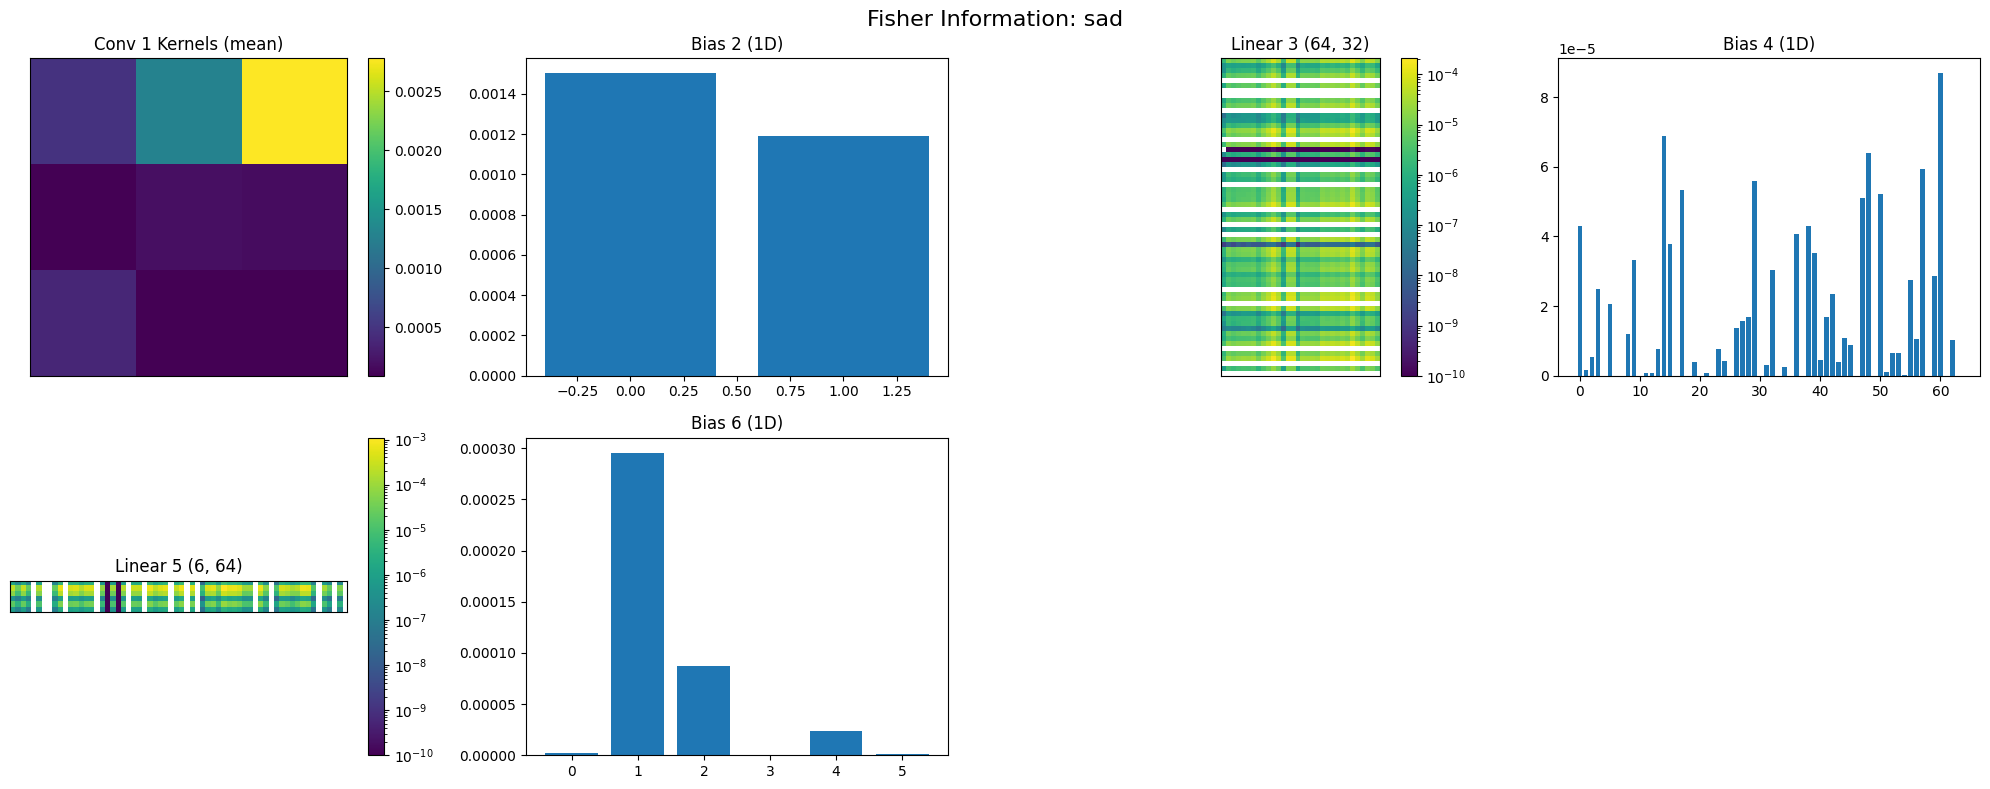

Visualizing Fisher Information for class: neutral


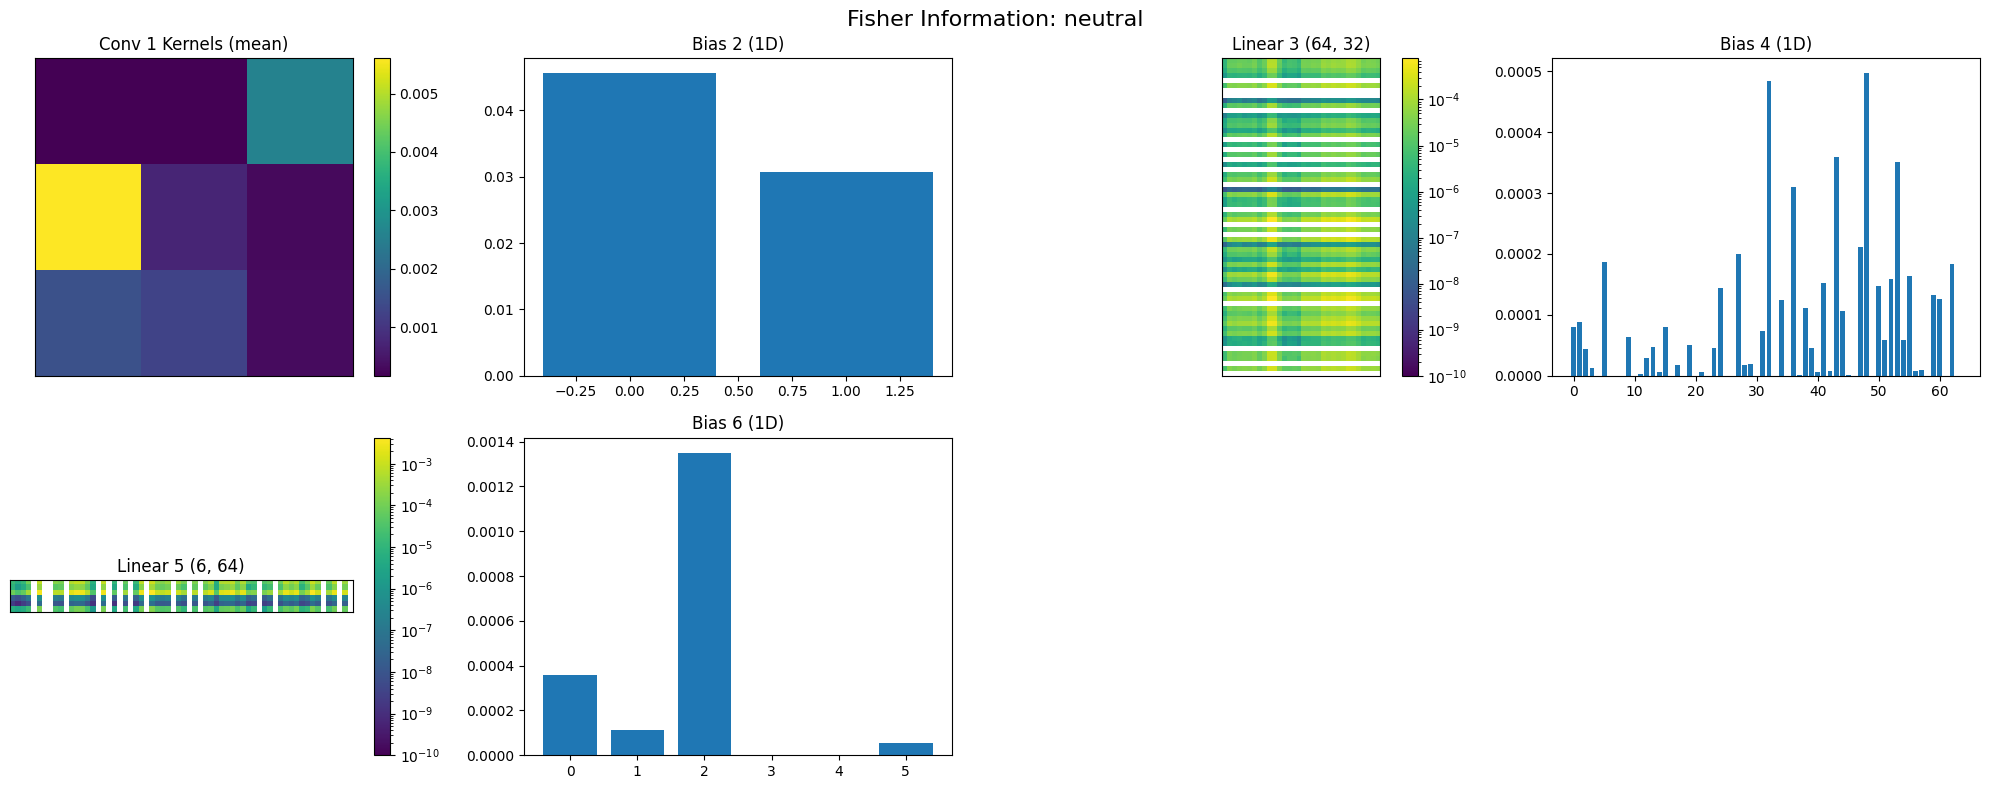

Visualizing Fisher Information for class: angry


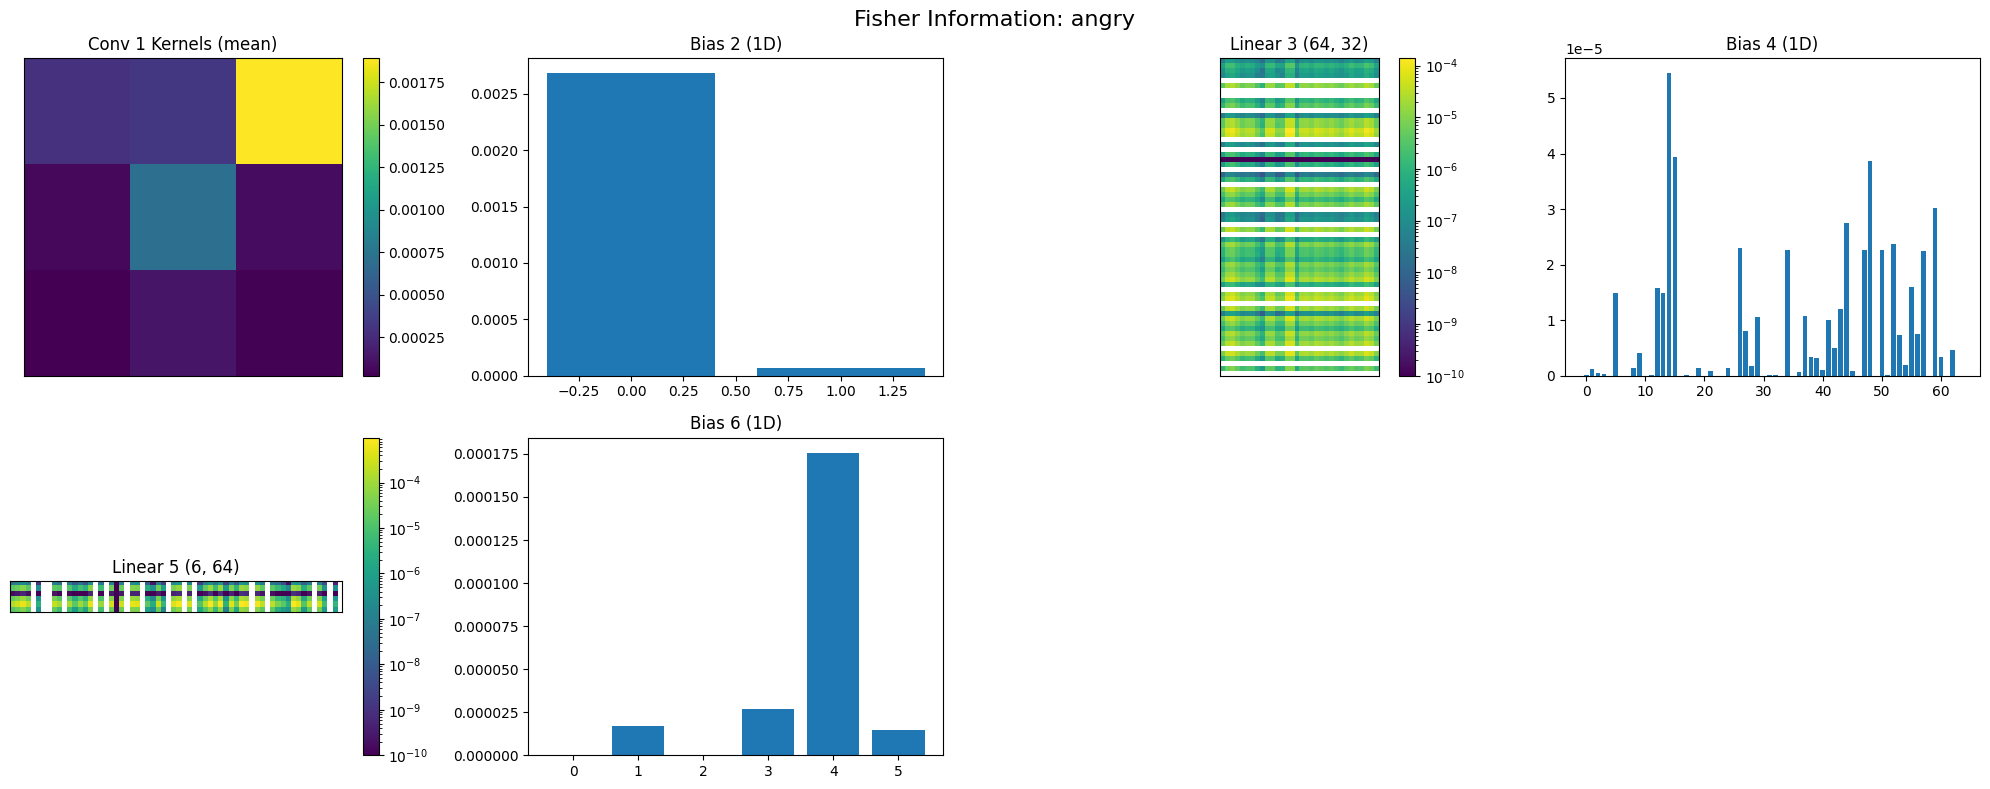

Visualizing Fisher Information for class: confused


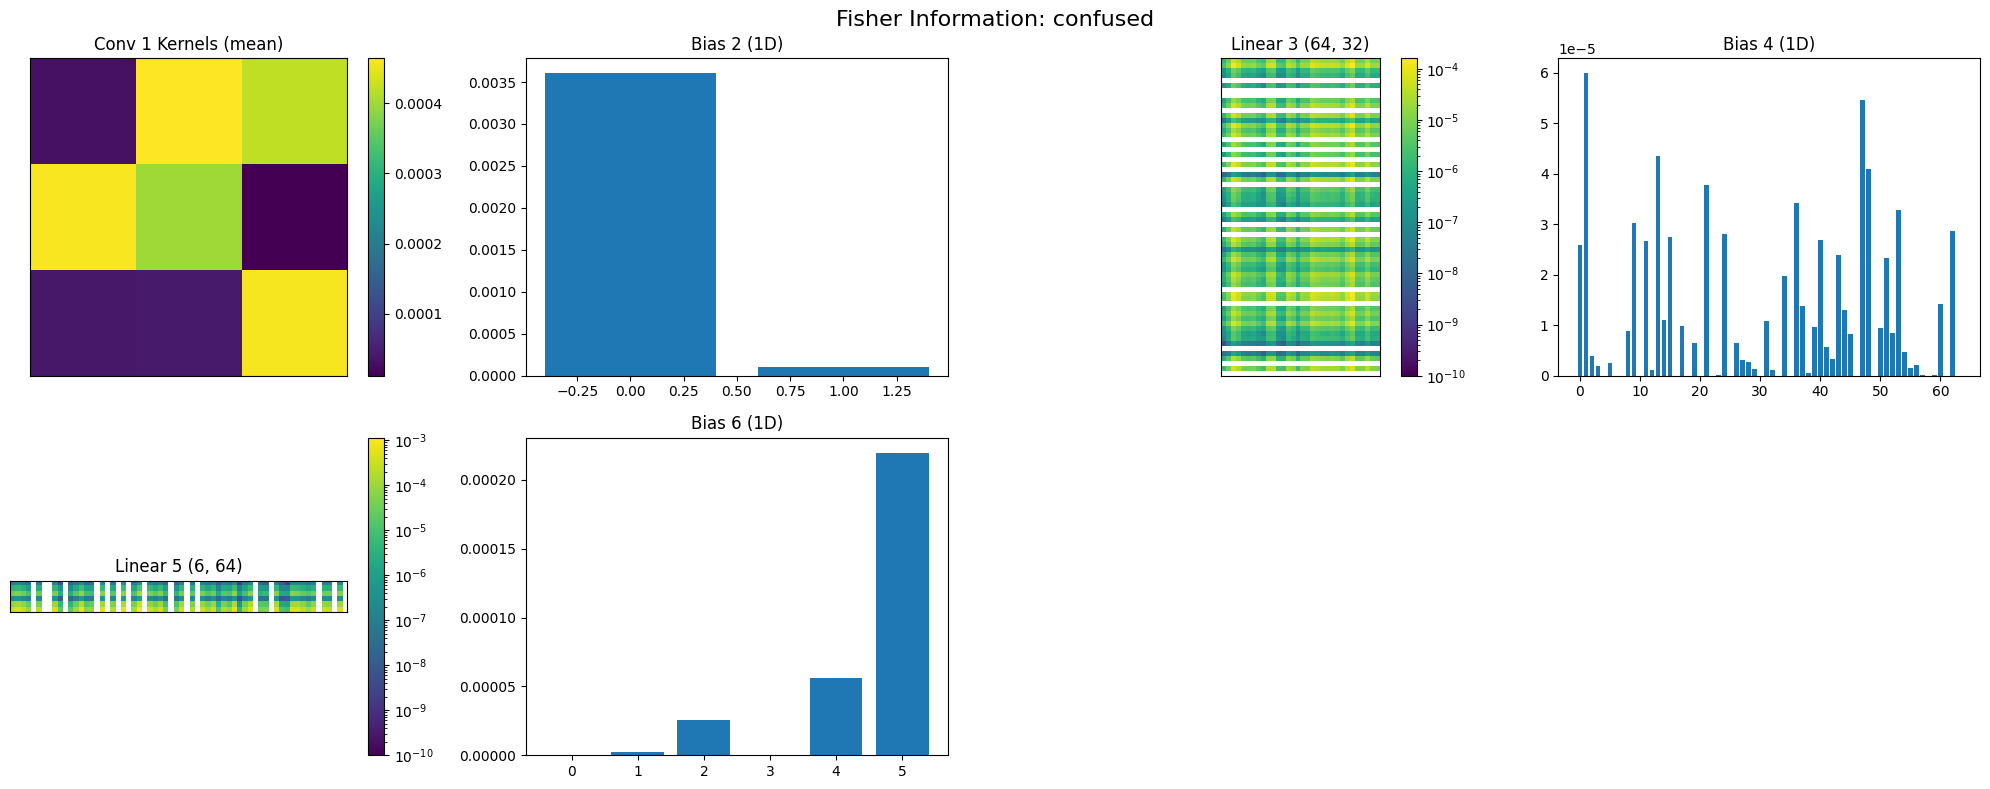

Visualizing Fisher Information for class: surprised


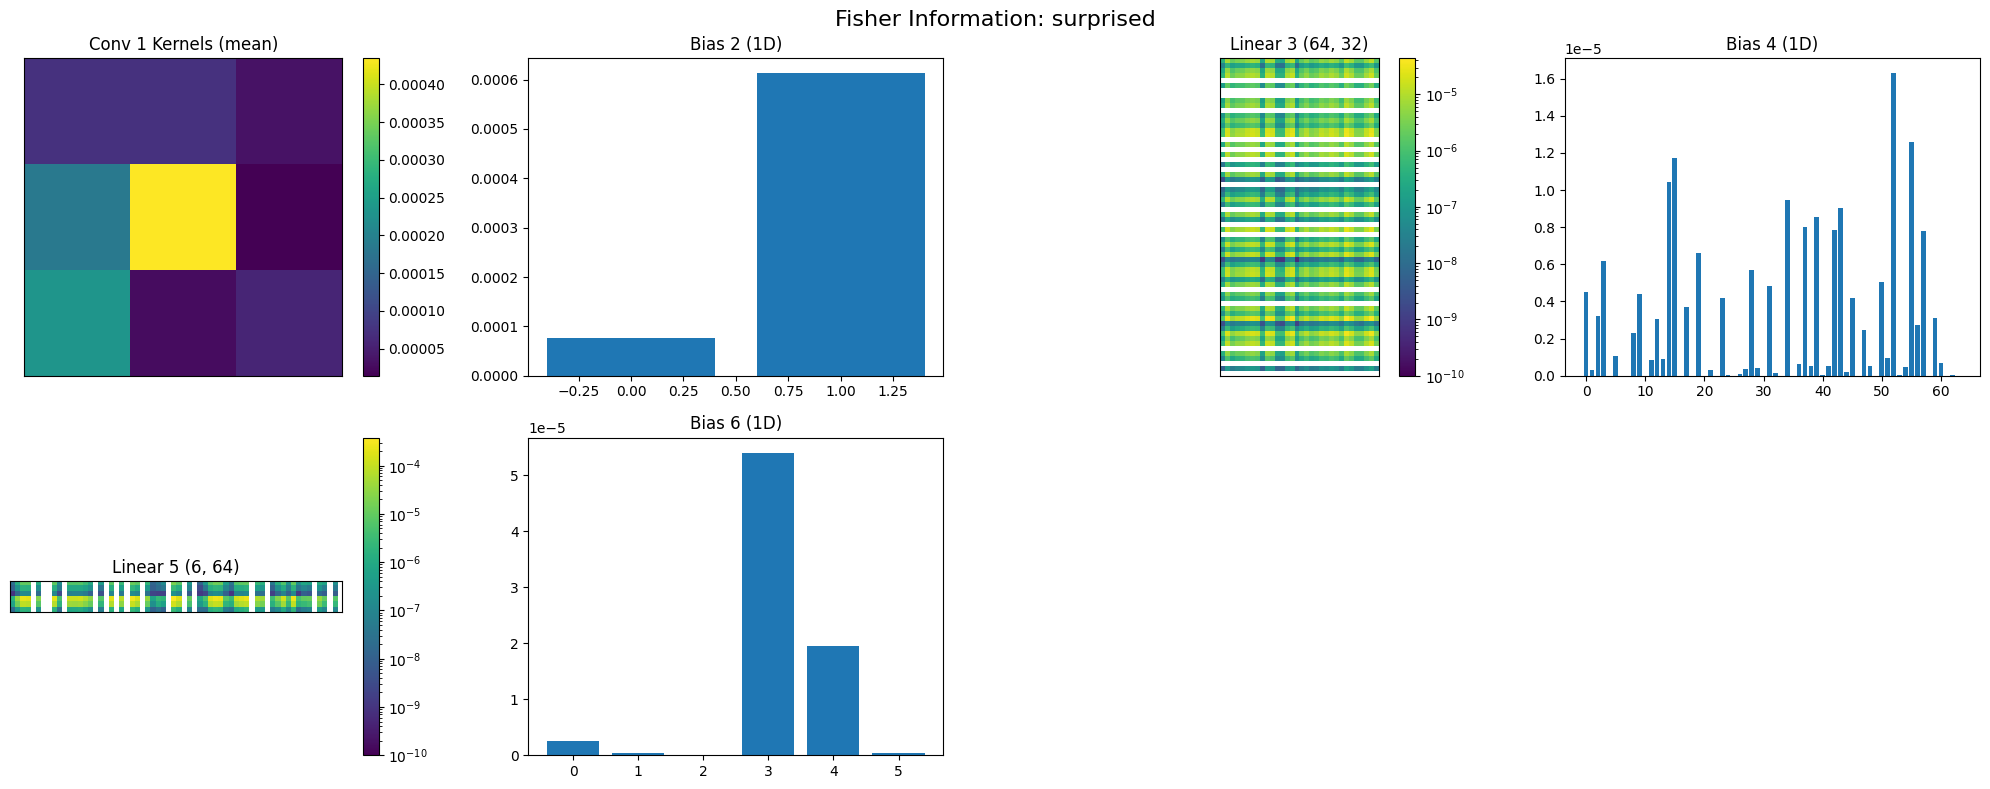

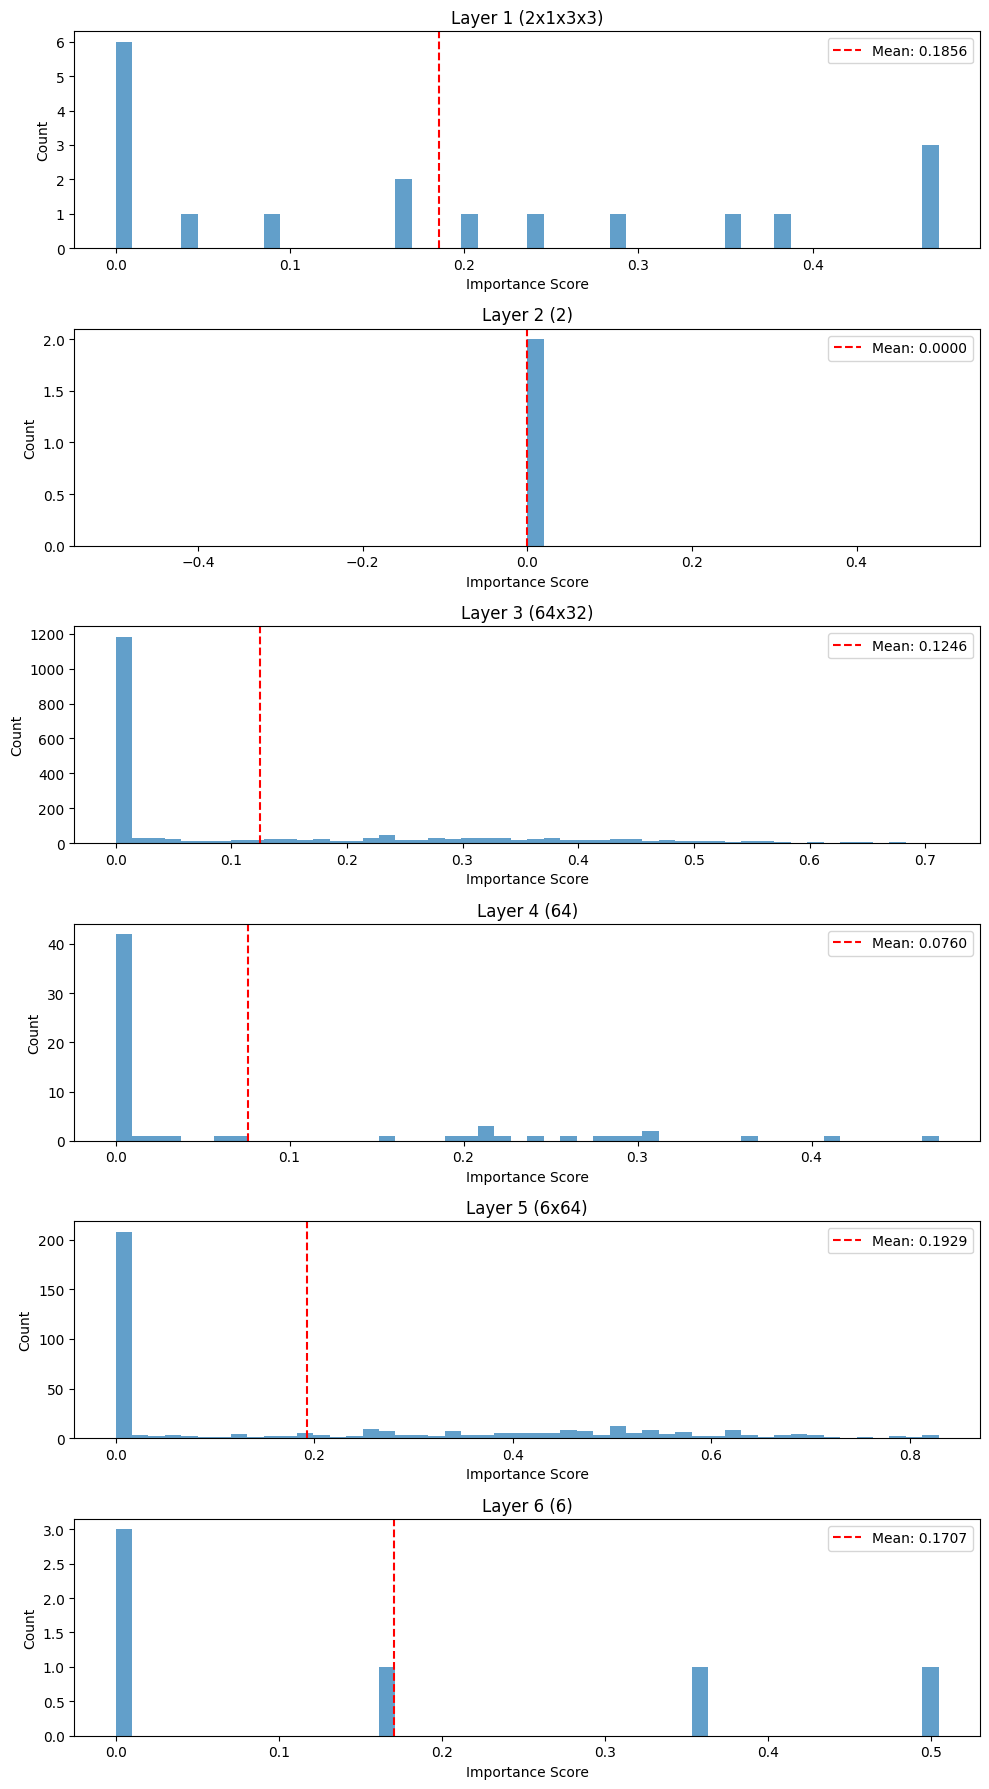

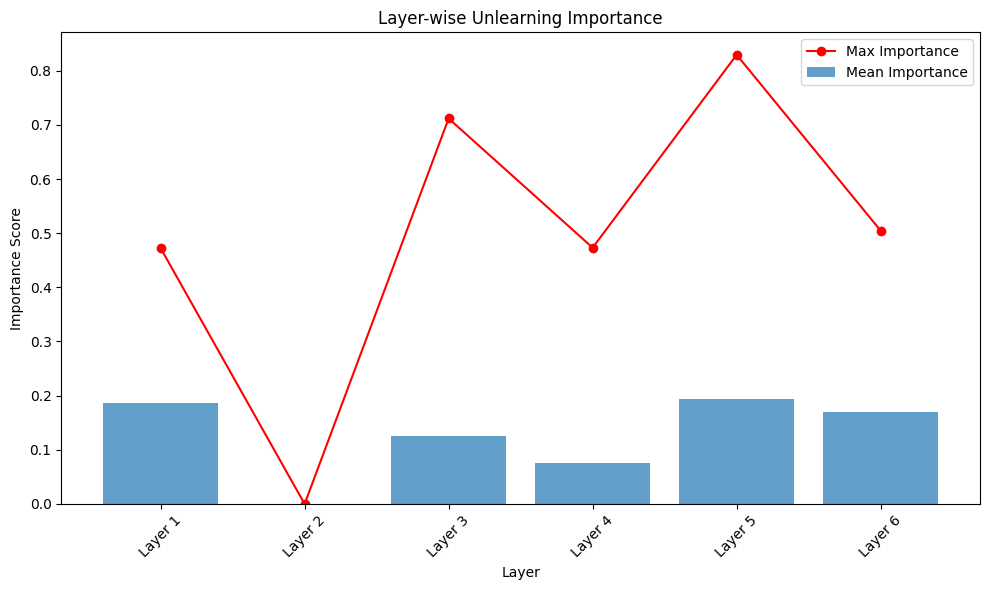

In [15]:
robust_fisher_heatmap(results["fisher_per_class"], list(class_datasets.keys()), model)

# Visualize importance scores by layer
plot_importance_by_layer(results["importance"], model)